<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/p5_notebook_2_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
t_init = time.time()
import pandas as pd
from collections import defaultdict as default_dict
from sqlite3 import connect
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import numpy as np
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [ ]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

# Pour activer l'optimisation baysienne des hyperparameters du modél DBscan il faut mettre cette variable à True
baysian_opt = False

# Démarche

Dans ce notebook, nous allons :

1. **Tester trois algorithmes de clustering** :  
   - **K-Means**  
   - **DBSCAN**  
   - **Agglomerative Hierarchical Clustering**  

2. **Comparer leurs performances** en utilisant deux métriques principales :  
   
- **Le Silhouette Score**

  Le Silhouette Score évalue à quel point un point est cohérent avec son cluster (cohésion intra-cluster) et séparé des autres clusters (séparation inter-cluster). Pour un point \( i \), on définit :

    $$
    s(i) = \frac{b(i) - a(i)}{\max\{a(i),\, b(i)\}},
    $$

    où :  
    - \( a(i) \) est la distance moyenne entre le point \( i \) et les autres points de **son** cluster,  
    - \( b(i) \) est la distance moyenne entre le point \( i \) et les points du **cluster le plus proche**.  

    La valeur de \( s(i) \) varie entre -1 et 1 :  
    - **\( s(i) \) proche de 1** : le point est bien séparé des autres clusters.  
    - **\( s(i) \) proche de 0** : le point est près de la frontière entre deux clusters.  
    - **\( s(i) \) négatif** : le point semble plus proche d’un autre cluster que du sien (mauvaise affectation).


- **Le Davies-Bouldin Score**

  Le Davies-Bouldin Score (\( DB \)) mesure la similarité moyenne entre les clusters en tenant compte de leur **dispersion interne** et de leur **distance mutuelle**. Il est défini comme suit :

  $$
  DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left(\frac{S_i + S_j}{d_{ij}}\right),
  $$

  où :  
  - \( S_i \) est la dispersion moyenne (intra-cluster) du cluster \( i \),  
  - \( d_{ij} \) est la distance entre les centroides des clusters \( i \) et \( j \).  

  Une **valeur faible** de \( DB \) indique des clusters **plus compacts** et **mieux séparés** (donc un meilleur clustering).

---


# 1 | Préparation des données

In [ ]:
data = pd.read_csv(folder_path + "olist_customer_cleaned_data.csv")
monetary_and_frequency_outliers = pd.read_csv(folder_path + "olist_customer_monetary_frequency_outliers.csv")
monetary_only_outliers = pd.read_csv(folder_path + "olist_customer_monetary_outliers.csv")
frequency_only_outliers = pd.read_csv(folder_path + "olist_customer_frequency_outliers.csv")

In [ ]:
data

,customer_unique_id,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,first_purch_at,last_purch_at,last_purch_day_of_week,customer_zip_code_prefix,rfm_segment_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,4.955123,8,413,5.0,1.0,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,3,7787,top (Gold)
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,3.302849,6,411,4.0,1.0,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,6053,risk (bronze)
2,0000f46a3911fa3c0805444483337064,536,1,4.456902,4,112,3.0,1.0,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,4,88115,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,3.775516,4,211,4.0,1.0,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,3,66812,inactive
4,0004aac84e0df4da2b147fca70cf8255,287,1,5.282645,7,214,5.0,1.0,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,1,18040,good (silver)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89392,fffbf87b7a1a6fa8b03f081c5f51a201,244,1,5.119908,6,213,5.0,1.0,1.0,2017-12-27 22:36:41,2017-12-27 22:36:41,2,60055,risk (bronze)
89393,fffea47cd6d3cc0a88bd621562a9d061,261,1,4.437698,5,212,4.0,1.0,1.0,2017-12-10 20:07:56,2017-12-10 20:07:56,6,44054,inactive
89394,ffff371b4d645b6ecea244b27531430a,567,1,4.722598,5,113,5.0,1.0,1.0,2017-02-07 15:49:16,2017-02-07 15:49:16,1,78552,inactive
89395,ffff5962728ec6157033ef9805bacc48,118,1,4.895524,7,313,5.0,1.0,1.0,2018-05-02 15:17:41,2018-05-02 15:17:41,2,29460,good (silver)


In [ ]:
data.describe()

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,last_purch_day_of_week,customer_zip_code_prefix
count,89397.000000,89397.0,89397.000000,89397.000000,89397.000000,89397.000000,89397.000000,89397.000000,89397.000000,89397.000000
mean,237.413358,1.0,4.660908,5.929886,263.893341,4.127969,1.132208,1.035784,2.755115,35210.199157
std,152.762223,0.0,0.757972,1.578280,111.731636,1.321565,0.493916,0.215940,1.967398,29838.239458
min,0.000000,1.0,2.516890,3.000000,111.000000,0.000000,1.000000,1.000000,0.000000,1003.000000
25%,114.000000,1.0,4.122122,5.000000,211.000000,4.000000,1.000000,1.000000,1.000000,11370.000000
50%,218.000000,1.0,4.646216,6.000000,311.000000,5.000000,1.000000,1.000000,3.000000,24451.000000
75%,346.000000,1.0,5.154043,7.000000,411.000000,5.000000,1.000000,1.000000,4.000000,59063.000000
max,694.000000,1.0,6.858155,9.000000,414.000000,5.000000,21.000000,7.000000,6.000000,99980.000000


In [ ]:
pca_2d_dict =  {}
pca_3d_dict =  {}
tsne_2d = {}
tsne_3d = {}
results = default_dict(dict)

def find_best_k(data):
  """
  Cette fonction permet d'estimer le meilleur k (nombre de cluster optimal) pour un dataset donné.
  data: dataframe
  return: silhouette_scores, dict_kmeans, best_silhouette_k
  """
  silhouette_scores = {}
  inertia_scores = {}
  dict_kmeans = {}

  for k in range(2, 15):
      kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
      cluster_labels = kmeans.predict(data)
      #silhouette_scores[k] = silhouette_score(data, cluster_labels, n_jobs=-1)
      inertia_scores[k] = kmeans.inertia_
      dict_kmeans[k] = kmeans

  #best_silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
  #print(f"best_k={best_silhouette_k}, best_silhouette_k={silhouette_scores[best_silhouette_k]}")
  return inertia_scores, dict_kmeans


def compute_silhouette_score(data, k_values):
  for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    cluster_labels = kmeans.predict(data)
    silhouette_scores[k] = silhouette_score(data, cluster_labels, n_jobs=-1)
    best_silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
    return silhouette_scores, best_silhouette_k

def plot_silhouette_scores(data, silhouette_scores, best_silhouette_k):
  fig = plt.figure(figsize=(18,5))

  plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker="o", linestyle="-", label="Score de silhouette")
  plt.axvline(x=best_silhouette_k, color="r", linestyle="--", label=f"Meilleur silhouette à k={best_silhouette_k}")
  plt.xlabel("Nombre de clusters (k)")
  plt.xlabel("Nombre de clusters (k)")
  plt.ylabel("Silhouette Score")
  plt.title("Score de silhouette en fonction de k")
  plt.legend()

  plt.show()

def plot_inertia_scores(inertia_scores):
  fig = plt.figure(figsize=(18,5))

  plt.plot(list(inertia_scores.keys()), list(inertia_scores.values()), marker="o", linestyle="-", label="Inertie")
  #plt.axvline(x=best_silhouette_k, color="r", linestyle="--", label=f"Meilleur silhouette à k={best_silhouette_k}")
  plt.xlabel("Nombre de clusters (k)")
  plt.ylabel("Inertie")
  plt.xlabel("Nombre de clusters (k)")
  plt.title("The Elbow method using Inertia")
  plt.legend()

  plt.show()

def plot_clusters(labels, X_pca_2d=None, X_pca_3d=None, title="Kmeans"):
  # Visualiser les résultats
  fig = plt.figure(figsize=(16, 8))

  cmap = mpl.colormaps.get_cmap('viridis')

  # Visualiser les résultats
  if X_pca_2d is not None:
    ax1 = fig.add_subplot(2,2,1)
    ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
    ax1.set_title(f"{title} Clustering with PCA 2D Visualization")
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')

  if X_pca_3d is not None:
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels, cmap='viridis', s=50, alpha=0.6)
    ax.set_title(f"{title} Clustering with PCA 3D Visualization")
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel("Component 3")
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)


  '''if X_tsne is not None:
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=labels, cmap='viridis', s=50, alpha=0.6)
    ax.set_title('K-means Clustering with t-SNE 3D Visualization')
    ax.set_xlabel("t-SNE1")
    ax.set_ylabel("t-SNE2")
    ax.set_zlabel("t-SNE3")

    ax = fig.add_subplot(2,2,4)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
    ax.set_title('K-means Clustering with t-SNE 2D Visualization')
    ax.set_xlabel("t-SNE1")
    ax.set_ylabel("t-SNE2")
  '''

  plt.show()


def get_pca(dim=2, selection='full', df=None):
  """
  dim: int => dimension de la projection
  selection: str => full ou rfm
  df: dataframe => dataframe à utiliser pour la projection
  return: X_pca
  """
  if selection == 'full':
    if dim == 2:
      if pca_2d_dict.get('full') is not None:
        return pca_2d_dict['full']
      pca = PCA(n_components=2)
      X_pca = pca.fit_transform(df)
      pca_2d_dict['full'] = (pca, X_pca)
      return (pca, X_pca)
    elif dim == 3:
      if pca_3d_dict.get('full') is not None:
        return pca_3d_dict['full']
      pca = PCA(n_components=3)
      X_pca = pca.fit_transform(df)
      pca_3d_dict['full'] = (pca, X_pca)
      return (pca, X_pca)
    else:
      raise ValueError("dim doit être 2 ou 3")
  else:
    if dim == 2:
      if pca_2d_dict.get(selection) is not None:
        return pca_2d_dict[selection]
      pca = PCA(n_components=2)
      X_pca = pca.fit_transform(df)
      pca_2d_dict[selection] = (pca, X_pca)
      return (pca, X_pca)
    elif dim == 3:
      if pca_3d_dict.get(selection) is not None:
        return pca_3d_dict[selection]
      pca = PCA(n_components=3)
      X_pca = pca.fit_transform(df)
      pca_3d_dict[selection] = (pca, X_pca)
      return (pca, X_pca)
    else:
      raise ValueError("dim doit être 2 ou 3")

# 2 | prévalence de la loyauté des clients

La segmentation RFM (Récence, Fréquence, Montant) nous a permis d’évaluer la fidélité des clients et de les classer en quatre segments distincts :  

1. **Gold (Clients Premium)** : Ces clients affichent des scores RFM élevés, indiquant une activité récente, une fréquence d’achat soutenue et des montants de dépenses significatifs. Ils représentent les clients les plus précieux.  

2. **Silver (Clients Loyaux)** : Ce segment regroupe les clients ayant un score élevé sur au moins un des trois critères (récence, fréquence ou montant). Ils sont engagés mais pourraient être encore plus valorisés.  

3. **Bronze (Clients à Risque)** : Ces clients montrent des signes de désengagement, avec une baisse de la fréquence ou de la récence de leurs achats. Il est essentiel d’anticiper leur attrition en mettant en place des actions ciblées.  

4. **Inactive (Clients Perdus)** : Ce segment comprend les clients inactifs depuis une période prolongée. Une stratégie de réactivation peut être envisagée pour les inciter à revenir.  

Cette segmentation permet d’optimiser les actions marketing en adaptant les stratégies d’engagement et de rétention en fonction du profil de chaque client.

In [ ]:
rfm_counts = data['rfm_segment_loyalty'].value_counts()

fig = px.pie(
    rfm_counts,
    values=rfm_counts.values,
    names=rfm_counts.index,
    title="Distribution des client par segment de Loyalty",
    hole=0
    )
fig.update_traces(textinfo="label+percent", textfont_size=12, rotation=90)
fig.update_layout(showlegend=True, legend_title_text="Segment de Loyalty")
fig.show()

# 3 | Standardisation des données

In [ ]:
num_cols = ['recency', 'frequency', 'monetary', 'satisfaction', 'nbre_items', 'distinct_products']
ss = StandardScaler()

In [ ]:
X_scaled = pd.DataFrame(ss.fit_transform(data[num_cols]), columns=num_cols)
X_scaled['customer_unique_id'] = data['customer_unique_id']
X_scaled.head()

,recency,frequency,monetary,satisfaction,nbre_items,distinct_products,customer_unique_id
0,-0.827522,0.0,0.388162,0.659852,-0.267675,-0.165715,0000366f3b9a7992bf8c76cfdf3221e2
1,-0.807883,0.0,-1.791711,-0.096832,-0.267675,-0.165715,0000b849f77a49e4a4ce2b2a4ca5be3f
2,1.954595,0.0,-0.269149,-0.853515,-0.267675,-0.165715,0000f46a3911fa3c0805444483337064
3,0.540625,0.0,-1.168114,-0.096832,-0.267675,-0.165715,0000f6ccb0745a6a4b88665a16c9f078
4,0.324602,0.0,0.820269,0.659852,-0.267675,-0.165715,0004aac84e0df4da2b147fca70cf8255


In [ ]:
monetary_and_frequency_outliers_scaled = pd.DataFrame(ss.fit_transform(monetary_and_frequency_outliers[num_cols]), columns=num_cols)
monetary_and_frequency_outliers_scaled['customer_unique_id'] = monetary_and_frequency_outliers['customer_unique_id']
monetary_and_frequency_outliers_scaled.head()

,recency,frequency,monetary,satisfaction,nbre_items,distinct_products,customer_unique_id
0,-0.681765,-0.450610,-1.000892,0.346934,-0.525815,-0.420716,012452d40dafae4df401bced74cdb490
1,-0.929020,-0.450610,1.224865,-0.507712,-0.525815,-0.420716,012a218df8995d3ec3bb221828360c86
2,-0.681765,0.486982,0.200355,0.204493,0.150611,-0.420716,02e9109b7e0a985108b43e573b6afb23
3,-1.190405,-0.450610,-0.998354,0.774256,-0.018495,-0.420716,032b3a42598667caf2e099999b9dc1b9
4,-0.794796,-0.450610,1.785103,0.774256,1.503464,-0.420716,0341bbd5c969923a0f801b9e2d10a7b8


In [ ]:
monetary_only_outliers_scaled = pd.DataFrame(ss.fit_transform(monetary_only_outliers[num_cols]), columns=num_cols)
monetary_only_outliers_scaled['customer_unique_id'] = monetary_only_outliers.customer_unique_id
monetary_only_outliers_scaled.head()

,recency,frequency,monetary,satisfaction,nbre_items,distinct_products,customer_unique_id
0,-1.264930,0.0,-0.699381,-0.571147,-0.320786,-0.169226,004df63539fd5e38d4b0a0506de7549c
1,-0.596850,0.0,0.275050,0.723006,-0.320786,-0.169226,005226be8d5b972d0f72b4e8a79f322b
2,0.325737,0.0,0.876723,-1.865299,0.292731,2.059554,00adeda9b742746c0c66e10d00ea1b74
3,-1.334920,0.0,1.020229,0.723006,-0.320786,-0.169226,00c07da5ba0e07b4f248a3a373b07476
4,1.814601,0.0,2.155660,0.723006,-0.320786,-0.169226,011875f0176909c5cf0b14a9138bb691


In [ ]:
frequency_only_outliers_scaled = pd.DataFrame(ss.fit_transform(frequency_only_outliers[num_cols]), columns=num_cols)
frequency_only_outliers_scaled['customer_unique_id'] = frequency_only_outliers.customer_unique_id
frequency_only_outliers_scaled.head()

,recency,frequency,monetary,satisfaction,nbre_items,distinct_products,customer_unique_id
0,0.031780,-0.191037,1.172206,0.741631,-0.395953,-0.288482,004288347e5e88a27ded2bb23747066c
1,-0.941615,-0.191037,-0.872788,-0.169762,-0.395953,-0.288482,00a39521eb40f7012db50455bf083460
2,2.103721,-0.191037,-0.826988,-0.169762,-0.395953,-0.288482,00cc12a6d8b578b8ebd21ea4e2ae8b27
3,-0.628738,-0.191037,0.203722,-0.625459,-0.395953,-0.288482,011575986092c30523ecb71ff10cb473
4,-0.190710,-0.191037,0.387535,0.285934,0.893423,-0.288482,011b4adcd54683b480c4d841250a987f


In [ ]:
rfm_feats = ['recency', 'frequency', 'monetary']
full_feats = ['recency', 'frequency', 'monetary', 'satisfaction', 'nbre_items', 'distinct_products']

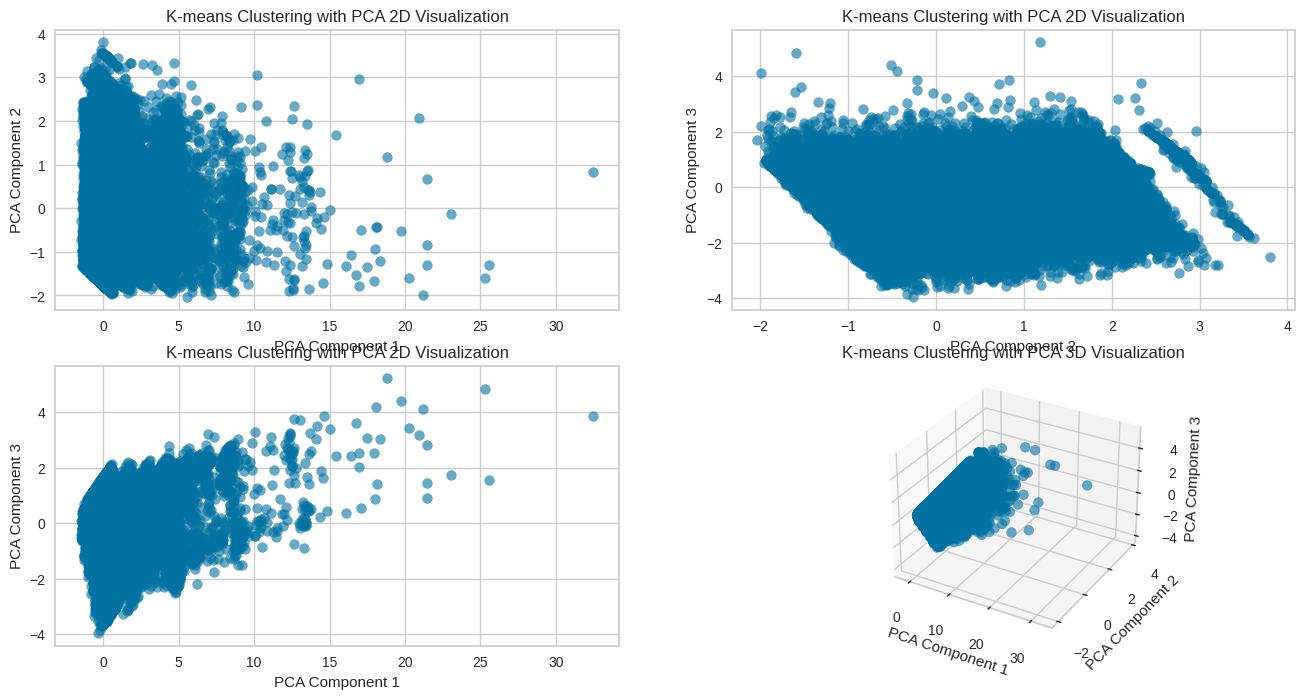

In [ ]:
fig = plt.figure(figsize=(16, 8))

cmap = mpl.colormaps.get_cmap('coolwarm')

X_pca = PCA(n_components=3).fit_transform(X_scaled[full_feats])

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(X_pca[:, 0], X_pca[:, 1], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 2D Visualization')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')

ax1 = fig.add_subplot(2,2,2)
ax1.scatter(X_pca[:, 1], X_pca[:, 2], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 2D Visualization')
ax1.set_xlabel('PCA Component 2')
ax1.set_ylabel('PCA Component 3')

ax1 = fig.add_subplot(2,2,3)
ax1.scatter(X_pca[:, 0], X_pca[:, 2], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 2D Visualization')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 3')

ax1 = fig.add_subplot(2,2,4, projection='3d')
ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 3D Visualization')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')

plt.show()

# 4 | K-Means Clustering

In [ ]:
kmeans_data = X_scaled.copy()
kmeans_data.head()

,recency,frequency,monetary,satisfaction,nbre_items,distinct_products,customer_unique_id
0,-0.827522,0.0,0.388162,0.659852,-0.267675,-0.165715,0000366f3b9a7992bf8c76cfdf3221e2
1,-0.807883,0.0,-1.791711,-0.096832,-0.267675,-0.165715,0000b849f77a49e4a4ce2b2a4ca5be3f
2,1.954595,0.0,-0.269149,-0.853515,-0.267675,-0.165715,0000f46a3911fa3c0805444483337064
3,0.540625,0.0,-1.168114,-0.096832,-0.267675,-0.165715,0000f6ccb0745a6a4b88665a16c9f078
4,0.324602,0.0,0.820269,0.659852,-0.267675,-0.165715,0004aac84e0df4da2b147fca70cf8255


## | 4.1 clustering avec les features rfm seulement

In [ ]:
first_selection_df = kmeans_data[rfm_feats]

In [ ]:
%%time
# Appliquer PCA pour réduire à 2 et 3 dimensions
pca_2d, X_pca_2d = get_pca(dim=2, selection='rfm', df=first_selection_df)
pca_3d, X_pca_3d = get_pca(dim=3, selection='rfm', df=first_selection_df)

print(f"Les deux dimensions capture {sum(pca_2d.explained_variance_ratio_ * 100)}")
print("-----"*9)
print(f"Les trois dimensions capture {sum(pca_3d.explained_variance_ratio_ * 100)}")
print("\n")

Les deux dimensions capture 99.99999999999999
---------------------------------------------
Les trois dimensions capture 99.99999999999999


CPU times: user 25.5 ms, sys: 0 ns, total: 25.5 ms
Wall time: 15.7 ms


### 4.1.1 | recherche du k optimal

In [ ]:
%%time
inertia_scores, dict_kmeans = find_best_k(first_selection_df.values)

CPU times: user 4.46 s, sys: 9.73 ms, total: 4.47 s
Wall time: 2.76 s


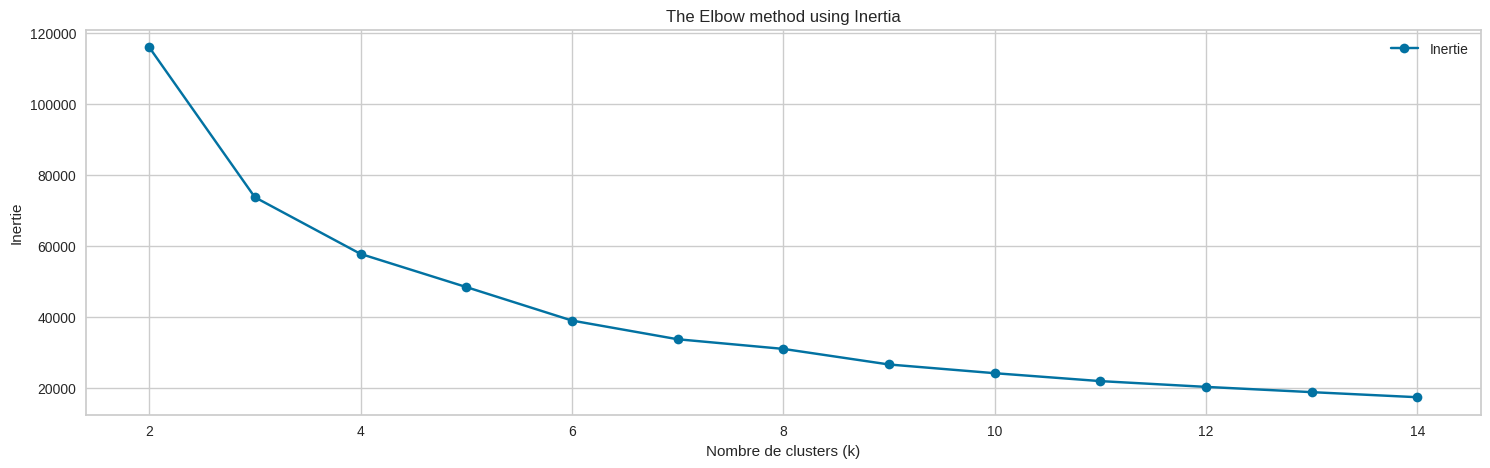

In [ ]:
plot_inertia_scores(inertia_scores=inertia_scores)

D'après la courbe d'inertie, on observe un coude marqué autour de k=4, k = 5 ou k = 6.
À partir de ce point, l'inertie diminue moins rapidement, ce qui indique un bon équilibre entre la compacité des clusters et leur nombre. Nous pouvons donc choisir k = 4, k = 5 ou k = 6 comme valeur optimale pour notre modèle de clustering.

Pour déterminer le meilleur choix de k, nous allons utiliser l'approche suivante:

- La visualisation des clusters : nous afficherons les clusters pour voir si la séparation est nette.
- Le score de silhouette: Nous choisirons le k ayant un meilleur score de silhouette

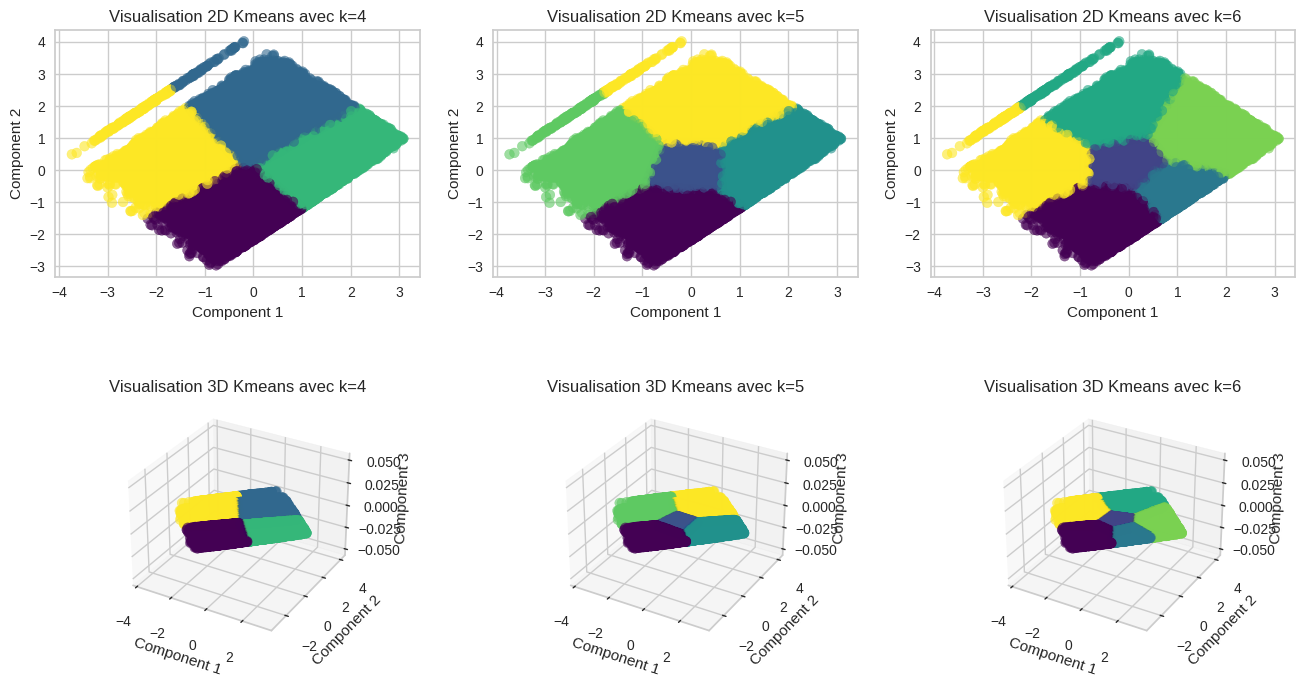

CPU times: user 5min 23s, sys: 1min 44s, total: 7min 8s
Wall time: 5min 38s


In [ ]:
%%time
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
cmap = mpl.colormaps.get_cmap('viridis')
silhouette_scores = {}

for i,k in enumerate([4, 5, 6]):

  kmeans_ = KMeans(n_clusters=k, random_state=42).fit(first_selection_df)
  labels_ = kmeans_.labels_
  silhouette_scores[k] = silhouette_score(first_selection_df, labels_, metric='euclidean')

  ax = fig.add_subplot(2,3,i+1)
  ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c=labels_, cmap='viridis', s=50, alpha=0.6)
  ax.set_title(f"Visualisation 2D Kmeans avec k={k}")
  ax.set_xlabel('Component 1')
  ax.set_ylabel('Component 2')

  ax = fig.add_subplot(2,3,i+4, projection='3d')
  ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_, cmap='viridis', s=50, alpha=0.6)
  ax.set_title(f"Visualisation 3D Kmeans avec k={k}")
  ax.set_xlabel('Component 1')
  ax.set_ylabel('Component 2')
  ax.set_zlabel("Component 3")

plt.show()

In [ ]:
silhouette_scores

{4: np.float64(0.34303312942280223),
 5: np.float64(0.33133972512417004),
 6: np.float64(0.34857125277075646)}

In [ ]:
best_silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"best_k={best_silhouette_k}, best_silhouette_score={silhouette_scores[best_silhouette_k]}")

best_k=6, best_silhouette_score=0.34857125277075646


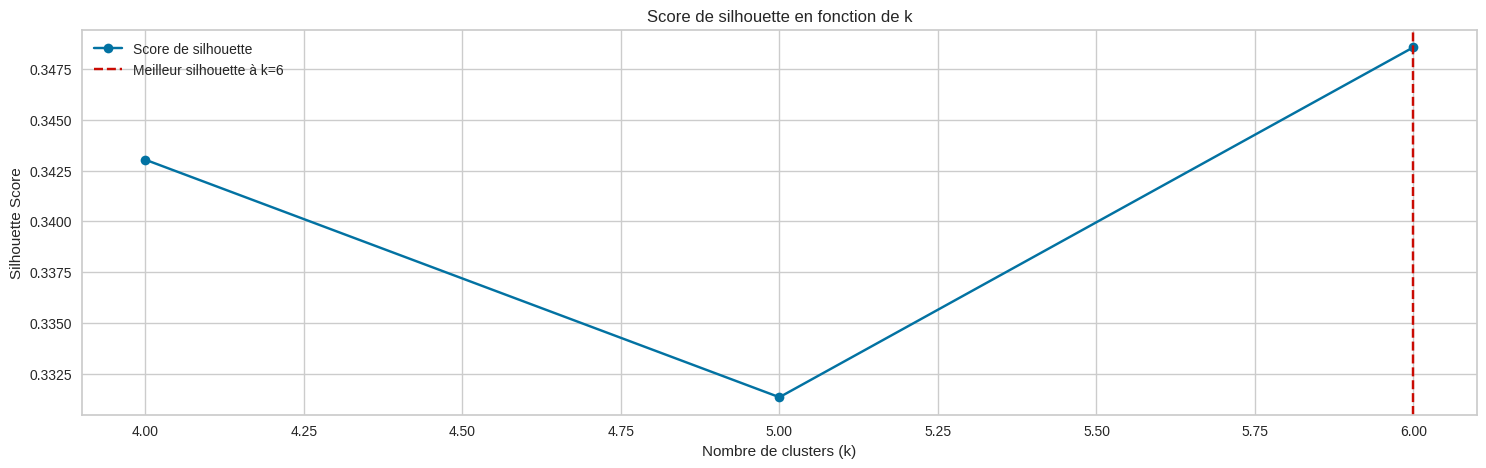

In [ ]:
plot_silhouette_scores(data=first_selection_df, silhouette_scores=silhouette_scores, best_silhouette_k=best_silhouette_k)

En comparant les visualisations :  

- Le graphique montre clairement que la silhouette est la plus élevée à k=6.
Un score de silhouette plus élevé indique que les clusters sont mieux séparés et plus homogènes.
- Les représentations 2D et 3D pour k=6 montrent des groupes relativement nets et distincts.

**Conclusion** : Au vu des résultats (score de silhouette et visualisations), k=6 paraît le plus approprié pour segmenter votre jeu de données.

### 4.1.2 | Kmean avec  k=6

In [ ]:
%%time
kmeans = KMeans(n_clusters=best_silhouette_k, random_state=42).fit(first_selection_df)
labels = kmeans.labels_
first_selection_df.loc[:, "cluster"] = labels

CPU times: user 247 ms, sys: 0 ns, total: 247 ms
Wall time: 248 ms


<timed exec>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



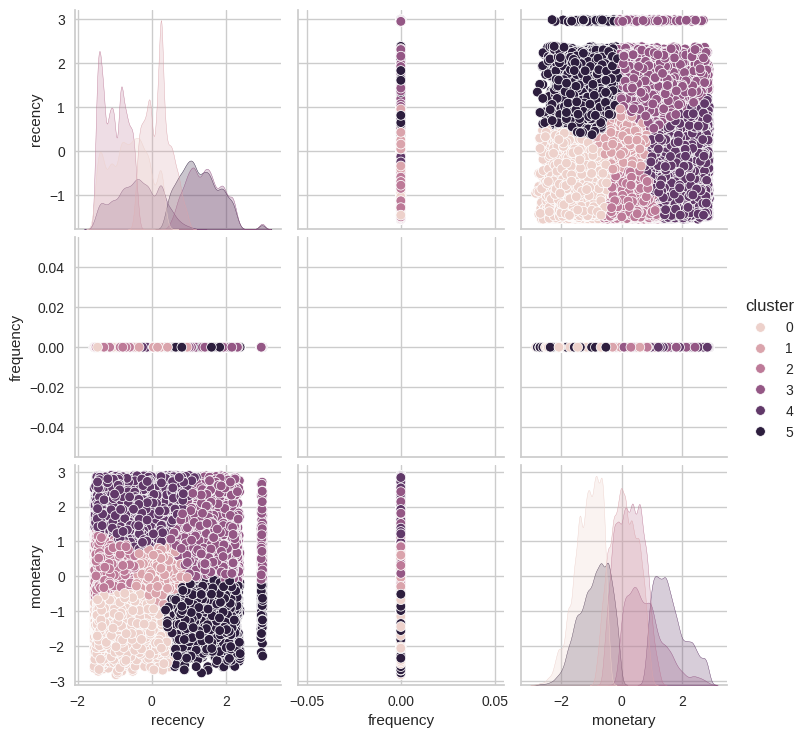

CPU times: user 52.6 s, sys: 279 ms, total: 52.9 s
Wall time: 52.1 s


In [ ]:
%%time
sns.pairplot(first_selection_df, hue="cluster")
plt.show()

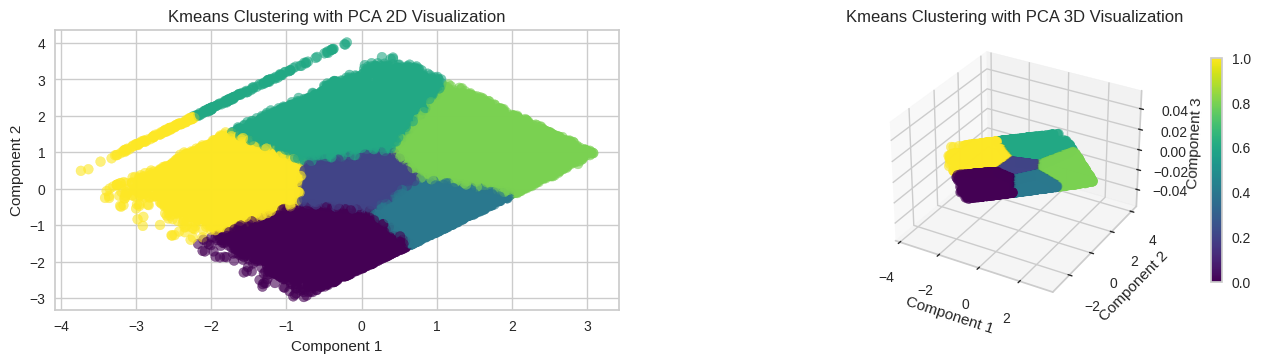

In [ ]:
# Visualiser les résultats en 3D et 2D
plot_clusters(labels, X_pca_2d, X_pca_3d)

## | 4.2 clustering avec l'ensemble des features

In [ ]:
%%time
X = kmeans_data.copy()
# Appliquer PCA pour réduire à 2 et 3 dimensions
pca_2d, X_pca_2d = get_pca(dim=2, selection='full', df=X[full_feats])
pca_3d, X_pca_3d = get_pca(dim=3, selection='full', df=X[full_feats])

print(f"Les deux dimensions capture {sum(pca_2d.explained_variance_ratio_ * 100)}")
print("-----"*9)
print(f"Les trois dimensions capture {sum(pca_3d.explained_variance_ratio_ * 100)}")
print("\n")

Les deux dimensions capture 52.63596400575743
---------------------------------------------
Les trois dimensions capture 71.71568018205656


CPU times: user 43.2 ms, sys: 0 ns, total: 43.2 ms
Wall time: 34.2 ms


### 4.2.1 | recherche du k optimal

In [ ]:
%%time
inertia_scores, dict_kmeans = find_best_k(X[full_feats].values)

CPU times: user 4.61 s, sys: 7.4 ms, total: 4.62 s
Wall time: 2.74 s


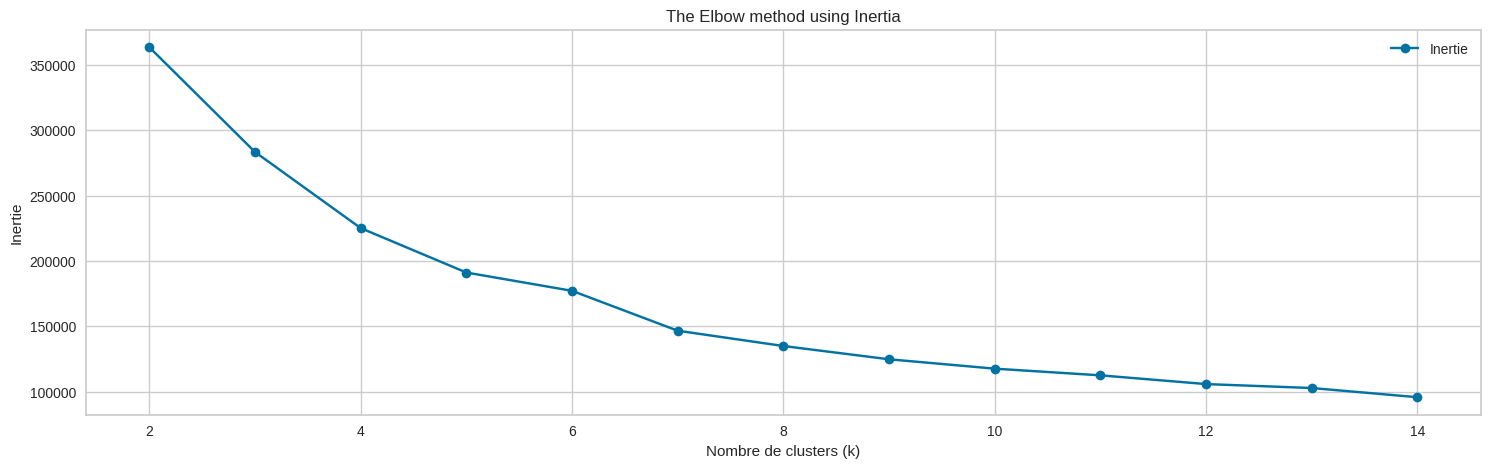

In [ ]:
plot_inertia_scores(inertia_scores=inertia_scores)

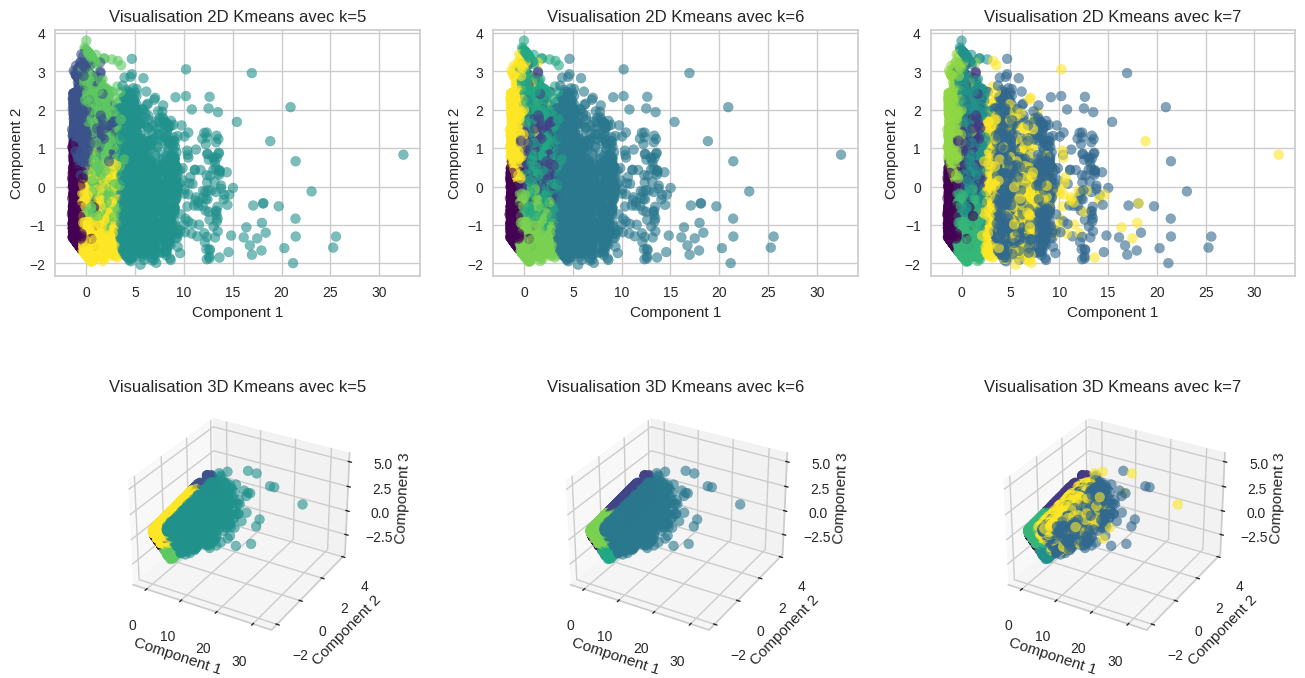

CPU times: user 5min 19s, sys: 1min 41s, total: 7min 1s
Wall time: 5min 30s


In [ ]:
%%time
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
cmap = mpl.colormaps.get_cmap('viridis')
silhouette_scores = {}

for i,k in enumerate([5, 6, 7]):

  kmeans_ = KMeans(n_clusters=k, random_state=42).fit(X[full_feats])
  labels_ = kmeans_.labels_
  silhouette_scores[k] = silhouette_score(X[full_feats], labels_, metric='euclidean')

  ax = fig.add_subplot(2,3,i+1)
  ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], c=labels_, cmap='viridis', s=50, alpha=0.6)
  ax.set_title(f"Visualisation 2D Kmeans avec k={k}")
  ax.set_xlabel('Component 1')
  ax.set_ylabel('Component 2')

  ax = fig.add_subplot(2,3,i+4, projection='3d')
  ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_, cmap='viridis', s=50, alpha=0.6)
  ax.set_title(f"Visualisation 3D Kmeans avec k={k}")
  ax.set_xlabel('Component 1')
  ax.set_ylabel('Component 2')
  ax.set_zlabel("Component 3")

plt.show()

best_k=5, best_silhouette_score=0.2861222027730799


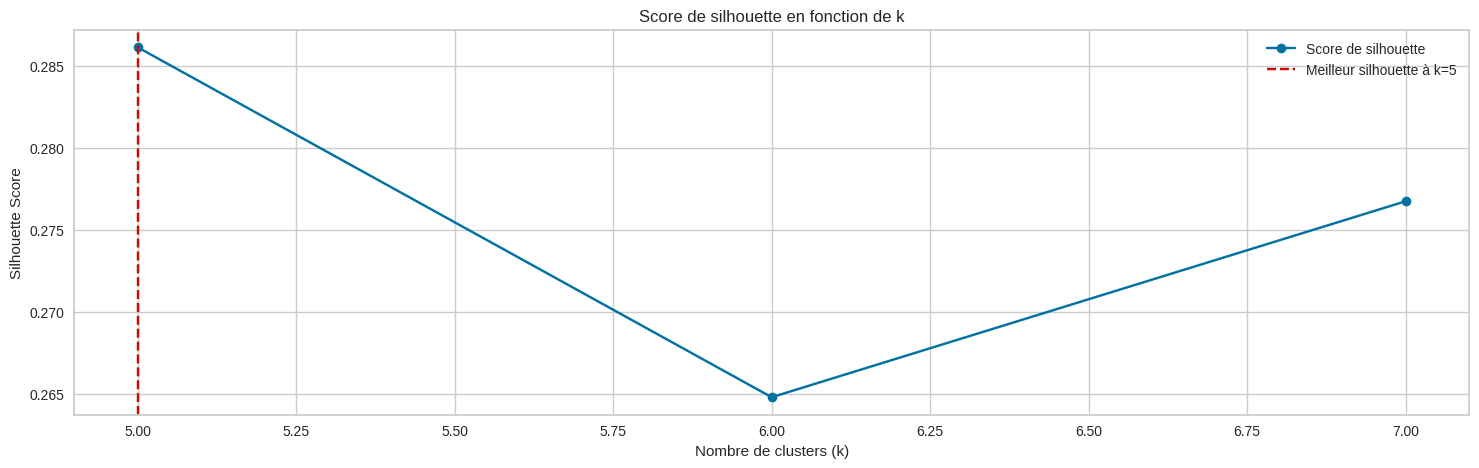

In [ ]:
best_silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"best_k={best_silhouette_k}, best_silhouette_score={silhouette_scores[best_silhouette_k]}")
plot_silhouette_scores(data=first_selection_df, silhouette_scores=silhouette_scores, best_silhouette_k=best_silhouette_k)

En comparant les visualisations :  
- Avec 𝑘=5: Les clusters semblent mieux définis avec un meilleur silhouette

**Conclusion**: Le nombre de clusters diminue malgré l'ajout de nouvelles variables, cela signifie que la structure globale des données est déjà mieux capturée par les variables RFM. Cependant on observe que les clusters sont mieux separés (inertie-inter class plus grand) avec les données rfm.

Pour la suite de notre modélisation nous allons uniquement considérés les données rfm.

## 4.3 | Kmean RFM avec  k=6

In [ ]:
%%time
kmeans = KMeans(n_clusters=6, random_state=42).fit(first_selection_df)
labels = kmeans.labels_
first_selection_df.loc[:, "cluster"] = labels
results["KMEANS"] = {
    'Number of clusters': 6,
    'Silhouette score': silhouette_score(first_selection_df, labels, metric='euclidean'),
    'Davies-Bouldin score': davies_bouldin_score(first_selection_df, labels),
    }

CPU times: user 1min 43s, sys: 36.2 s, total: 2min 19s
Wall time: 1min 48s


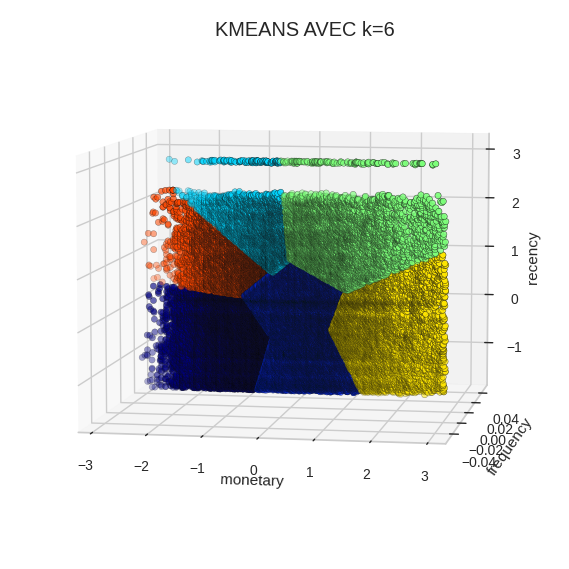

In [ ]:
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d", elev=7, azim=-80)
ax1.set_position([0, 0, 0.95, 1])
ax1.set_xlabel('monetary')
ax1.set_ylabel('frequency')
ax1.set_zlabel("recency")
for l in np.unique(labels):
    ax1.scatter(
        first_selection_df.loc[first_selection_df.cluster == l, 'monetary'],
        first_selection_df.loc[first_selection_df.cluster  == l, 'frequency'],
        first_selection_df.loc[first_selection_df.cluster  == l, 'recency'],
        color=plt.cm.jet(float(l) / np.max(labels + 1)),
        s=20,
        edgecolor="k",
    )
_ = fig1.suptitle(f"KMEANS AVEC k=6")
plt.show()

# 5 | DBscan Clustering

Le dbscan(density-based spatial clustering of applications with noise) est un algorithme non supervisé trés simple.

Il definit les clusters en se basant sur la densité des points.

L'algorithme peut etre divisé en 4 phase:

1. Pour chaque observation (point) on regarde le nombre de points à au plus une distance epsilon e (On appelle e: e voisinage de l'observation)
2. Si une observation compte au moins un certain nobmre de voisins y compris elle-meme, elle est considerée comme une **observation coeur** -> Observation à haute densité.
3. Toutes les observations au voisinage d'une observation coeur appartiennent au meme cluster.
4. Toute observation qui n'est pas une observation coeur dans son voisinage est considérée comme une anomalie.

Concernant le choix du epsilon, notre approche consiste alors à utiliser la librairie **NearestNeighbors** de sckit-learn  pour fixer le epsilon optimal.

In [ ]:
%%time
dbscan_data= X_scaled[rfm_feats].copy()
# Appliquer PCA pour réduire à 2 et 3 dimensions
pca_2d, X_pca_2d = get_pca(dim=2, selection='rfm', df=dbscan_data)
pca_3d, X_pca_3d = get_pca(dim=3, selection='rfm', df=dbscan_data)

print(f"Les deux dimensions capture {sum(pca_2d.explained_variance_ratio_ * 100)}")
print("-----"*9)
print(f"Les trois dimensions capture {sum(pca_3d.explained_variance_ratio_ * 100)}")
print("\n")

Les deux dimensions capture 99.99999999999999
---------------------------------------------
Les trois dimensions capture 99.99999999999999


CPU times: user 23.9 ms, sys: 411 µs, total: 24.3 ms
Wall time: 37.8 ms


## 5.1 | recherche du epsilon(e) optimal

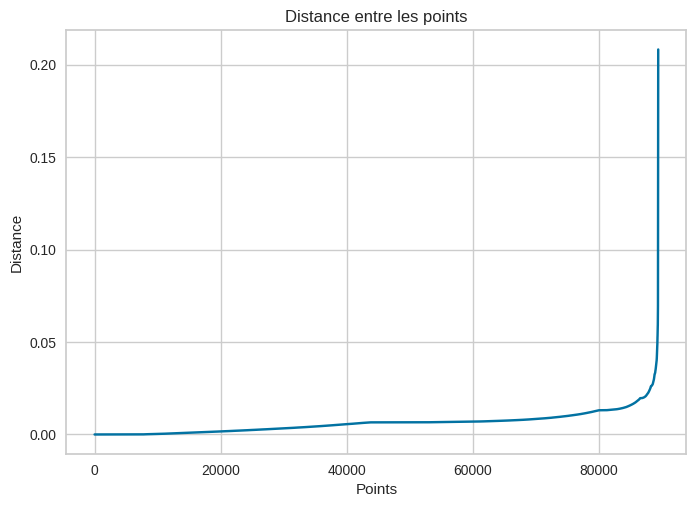

CPU times: user 450 ms, sys: 15.9 ms, total: 466 ms
Wall time: 504 ms


In [ ]:
%%time
nn = NearestNeighbors(n_neighbors=2)
nn_fit = nn.fit(dbscan_data)
distances, indices = nn_fit.kneighbors(dbscan_data)
distances = distances[:,1]
distances = np.sort(distances, axis=0)
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.title("Distance entre les points")
plt.show()

In [ ]:
mask = distances < 0.04
new_arr = distances[mask]
print(len(new_arr))
display(distances[mask])

89146


array([0.        , 0.        , 0.        , ..., 0.03987033, 0.03991801,
       0.03992651])

In [ ]:
if baysian_opt:
  !pip install optuna
  import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 22.2 MB/s eta 0:00:00


In [ ]:
%%time
# Fonction d'optimisation
def lgb_objective(trial):
    param = {
        'eps': trial.suggest_float('eps', 0.1, 0.20),
        'min_samples': trial.suggest_int('min_samples', 200, 1000)
    }

    dbscan = DBSCAN(**param, n_jobs=-1)
    labels_dbscan = dbscan.fit_predict(dbscan_data)
    if len(np.unique(labels_dbscan)) == 1:
        return -1000
    score = silhouette_score(dbscan_data, labels_dbscan, metric='euclidean')

    return score

if baysian_opt:
  # HPO pour DBSCAN
  study = optuna.create_study(direction='maximize')
  study.optimize(lgb_objective, n_trials=50)

[I 2025-03-23 14:08:25,031] A new study created in memory with name: no-name-1ff8149d-71b1-49a5-82f6-56a1124ba826
[I 2025-03-23 14:10:04,502] Trial 0 finished with value: 0.3002749868122021 and parameters: {'eps': 0.19731304759593823, 'min_samples': 601}. Best is trial 0 with value: 0.3002749868122021.
[I 2025-03-23 14:10:06,475] Trial 1 finished with value: -1000.0 and parameters: {'eps': 0.10141478927089809, 'min_samples': 804}. Best is trial 0 with value: 0.3002749868122021.
[I 2025-03-23 14:11:46,190] Trial 2 finished with value: -0.40297874641967746 and parameters: {'eps': 0.10982312016440038, 'min_samples': 582}. Best is trial 0 with value: 0.3002749868122021.
[I 2025-03-23 14:13:21,336] Trial 3 finished with value: -0.2953424302153524 and parameters: {'eps': 0.11743775639965126, 'min_samples': 550}. Best is trial 0 with value: 0.3002749868122021.
[I 2025-03-23 14:14:55,910] Trial 4 finished with value: 0.24964433618238446 and parameters: {'eps': 0.15812545857327026, 'min_samples

CPU times: user 1h 26min 26s, sys: 19min 24s, total: 1h 45min 50s
Wall time: 1h 24min 30s


In [ ]:
if baysian_opt:
  print(f"#Meilleur score silhouette: {study.best_value}")
  print(f"#Meilleurs hyperparameters: {study.best_params}")
  print(f"#Meilleur essai: {study.best_trial.number}")
  print(f"#couple: {study.best_params['eps'], study.best_params['min_samples']}")

#Meilleur score silhouette: 0.38696598889009826
#Meilleurs hyperparameters: {'eps': 0.1916924963912447, 'min_samples': 206}
#Meilleur essai: 27
#couple: (0.1916924963912447, 206)


In [ ]:
#Meilleur score silhouette: 0.38696598889009826
#Meilleurs hyperparameters: {'eps': 0.1916924963912447, 'min_samples': 206}
#Meilleur essai: 27
#couple: (0.1916924963912447, 206)

#Meilleur score silhouette: 0.38583556471282016
#Meilleurs hyperparameters: {'eps': 0.19539928894352204, 'min_samples': 218}
#Meilleur essai: 11
#Couple: (0.19539928894352204, 218)

#Meilleur score silhouette: 0.379922844745928
#Meilleurs hyperparameters: {'eps': 0.1928310938294647, 'min_samples': 230}
#Couple: (0.1928310938294647, 230)

#Meilleur score silhouette: 0.3799204430083074
#Meilleurs hyperparameters: {'eps': 0.19706669595872509, 'min_samples': 240}
#Couple: (0.19706669595872509, 240)

#Meilleur score silhouette: 0.37991620122982706
#Meilleurs hyperparameters: {'eps': 0.18202046537988686, 'min_samples': 200}
#Couple: (0.18202046537988686, 200)

#Meilleur score silhouette: 0.37499057845244277
#Meilleurs hyperparameters: {'eps': 0.18863143629789725, 'min_samples': 235}
#Couple: (0.18863143629789725, 235)

#Meilleur score silhouette: 0.37496356563807604
#Meilleurs hyperparameters: {'eps': 0.17858703480826923, 'min_samples': 207}
#Couple: (0.17858703480826923, 207)

#Meilleur score silhouette: 0.37398162022035536
#Meilleurs hyperparameters: {'eps': 0.17910393780940687, 'min_samples': 210}
#Couple: (0.17910393780940687, 210)


#Meilleur score silhouette: 0.3698518577090045
#Meilleurs hyperparameters: {'eps': 0.19156022435299447, 'min_samples': 262}
#Couple: (0.19156022435299447, 262)

#Meilleur score silhouette: 0.3626634324430894
#Meilleurs hyperparameters: {'eps': 0.16288641328842232, 'min_samples': 203}
#Meilleur essai: 9
#couple: (0.16288641328842232, 203)

#Meilleur score silhouette: 0.3587388702758939
#Meilleurs hyperparameters: {'eps': 0.18940108003446873, 'min_samples': 299}
#Couple: (0.18940108003446873, 299)

#Meilleur score silhouette: 0.35634857382832247
#Meilleurs hyperparameters: {'eps': 0.1872286559654065, 'min_samples': 299}
#Couple: (0.1872286559654065, 299)

#Meilleur score silhouette: 0.3553956084827796
#Meilleurs hyperparameters: {'eps': 0.16014856546078235, 'min_samples': 217}
#Meilleur essai: 3
#couple: (0.16014856546078235, 217)

In [ ]:
# La relation entre chaque hyperparamètre et la valeur de la fonction objectif.
if baysian_opt:
  fig = optuna.visualization.plot_slice(study)
  fig.show()

In [ ]:
# La relation entre chaque hyperparamètre et la valeur de la fonction objectif.
if baysian_opt:
  optuna.visualization.plot_param_importances(study)

In [ ]:
if baysian_opt:
  fig = optuna.visualization.plot_contour(study, target_name='silhouette score', )
  fig.show()

In [ ]:
%%time
hyperparameters_combination = [(0.1916924963912447, 206), (0.19539928894352204, 218), (0.1928310938294647, 230), (0.16014856546078235, 217)]
fig = plt.figure(figsize=(16, 8))

best_comb_score = -1000
best_eps = None
best_min_samples = None
best_labels = None
for i, (eps, min_samples) in enumerate(hyperparameters_combination):
  dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
  labels_dbscan = dbscan.fit_predict(dbscan_data)
  score = silhouette_score(dbscan_data, labels_dbscan, metric='euclidean')
  if score > best_comb_score:
    best_comb_score = score
    best_eps = eps
    best_min_samples = min_samples
    best_labels = labels_dbscan

In [ ]:
%%time
print(f"Meilleur score silhouette: {best_comb_score}")
print(f"Meilleurs hyperparameters: {{'eps':{best_eps}, 'min_samples'={best_min_samples}}}")

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1)
dbscan.fit(dbscan_data)
labels_dbscan = dbscan.labels_

Meilleur score silhouette: 0.38696598889009826
Meilleurs hyperparameters: {'eps':0.1916924963912447, 'min_samples'=206}
CPU times: user 5.08 s, sys: 444 ms, total: 5.53 s
Wall time: 3.34 s


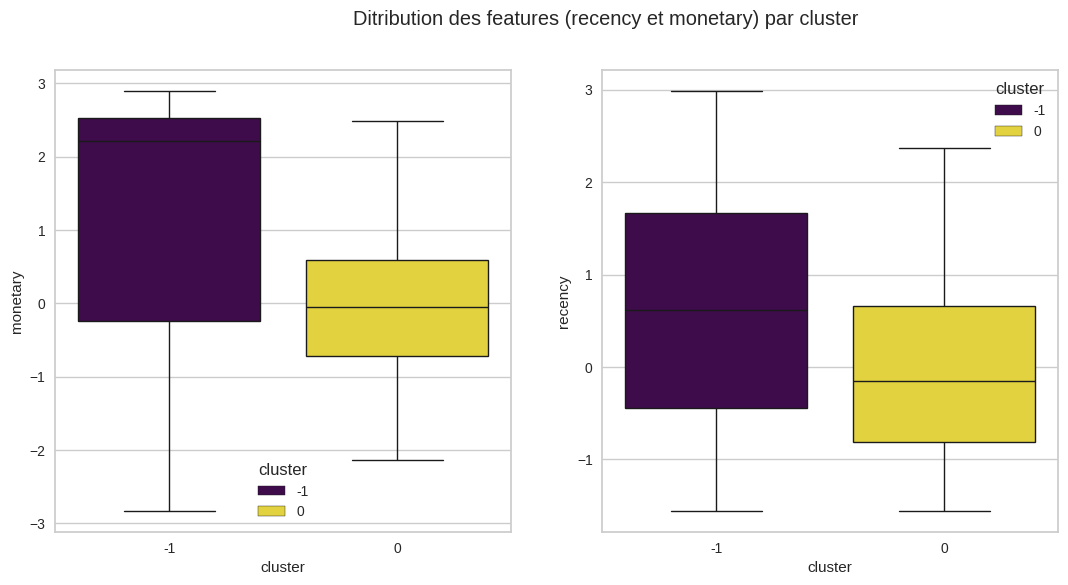

cluster              -1         0
recency  mean  0.643470 -0.026984
         min  -1.554145 -1.554145
         max   2.988888  2.373549
monetary mean  1.184687 -0.049680
         min  -2.828642 -2.139455
         max   2.898867  2.485400

In [ ]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
df_copy = dbscan_data.copy()
df_copy['cluster'] = labels_dbscan

fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1,3,1)
sns.boxplot(data=df_copy, x='cluster', y='monetary', hue='cluster', ax=ax1, palette='viridis')
ax2 = fig.add_subplot(1,3,2)
sns.boxplot(data=df_copy, x='cluster', y='recency', hue='cluster', ax=ax2, palette='viridis')

fig.suptitle('Ditribution des features (recency et monetary) par cluster', x=0.4)
plt.show()

df_copy.groupby('cluster').agg({
    'recency': ['mean', 'min', 'max'],
    'monetary': ['mean', 'min', 'max']}).T

In [ ]:
results

defaultdict(dict,
            {'DBSCAN': {'Number of clusters': 2,
              'Silhouette score': np.float64(0.38696598889009826),
              'Davies-Bouldin score': np.float64(2.3713361761508227)}})

In [ ]:
%%time
results["DBSCAN"] = {
    'Number of clusters': 2,
    'Silhouette score': silhouette_score(dbscan_data, labels_dbscan, metric='euclidean'),
    'Davies-Bouldin score': davies_bouldin_score(dbscan_data, labels_dbscan),
    }

CPU times: user 1min 41s, sys: 22.8 s, total: 2min 3s
Wall time: 1min 40s


# 6 | Hierarchical Agglomerative Clustering (HAC)

In [ ]:
hac_data= X_scaled[rfm_feats].sample(20000, random_state=42)

In [ ]:
%%time
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
Z = linkage(hac_data, method='ward')

CPU times: user 32.7 s, sys: 4.61 s, total: 37.3 s
Wall time: 37.3 s


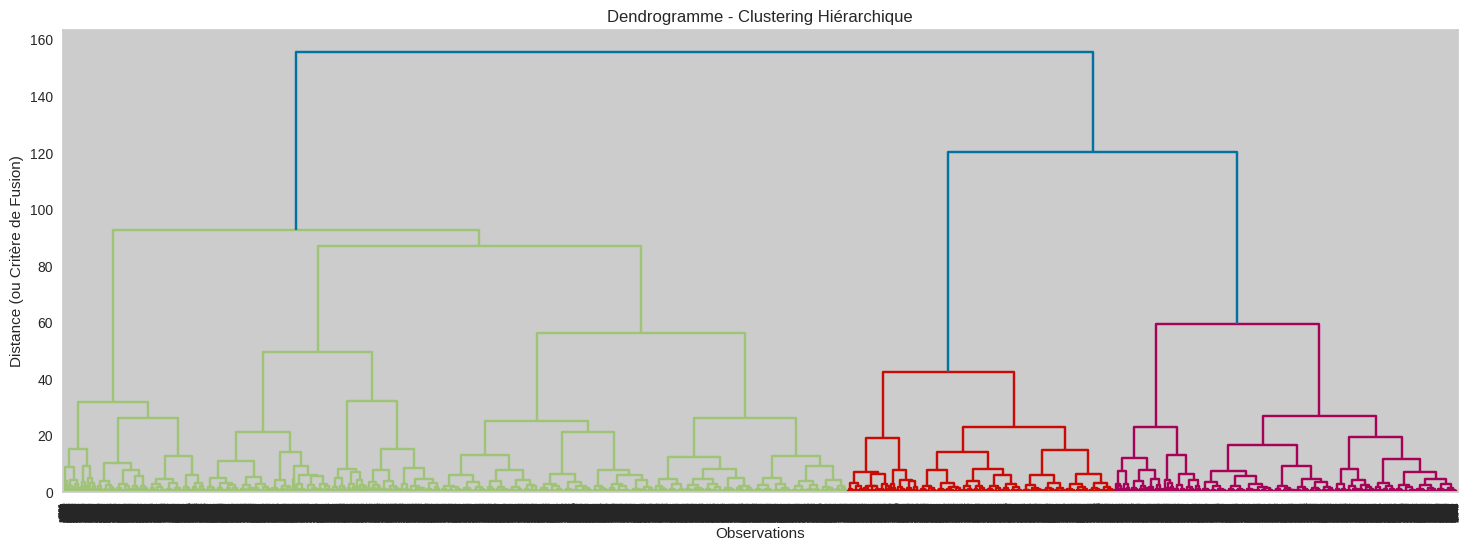

CPU times: user 1min 59s, sys: 3.84 s, total: 2min 2s
Wall time: 2min 3s


In [ ]:
%%time
plt.figure(figsize=(18, 6))
dendrogram(Z)
plt.title('Dendrogramme - Clustering Hiérarchique')
plt.xlabel('Observations')
plt.ylabel('Distance (ou Critère de Fusion)')
plt.show()

### 6.1 | Recherche du k optimal

Pour determiner le meilleur k nous allons construire une hierarchie pour k=2 à k=20 en evaluant le score Calinski and Harabasz Index (CH Index). Le meilleur k correspond à celui ayant un score plus elévé.

L'indice de Calinski-Harabasz (CH) pour un nombre de clusters \(K\) est défini par :

$$
CH(K) = \frac{B(K)/(K-1)}{W(K)/(n-K)}
$$

Où :
- \(B(K)\) représente la dispersion entre les clusters,
- \(W(K)\) représente la dispersion intra-cluster,
- \(K\) est le nombre de clusters,
- \(n\) est le nombre total de points.

In [ ]:
%%time
calinski_harabasz_scores = {}
for k in range(2, 15):
    cluster = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    cluster.fit(hac_data)
    score = calinski_harabasz_score(hac_data, cluster.labels_)
    calinski_harabasz_scores[k] = score

CPU times: user 6min 55s, sys: 25.4 s, total: 7min 20s
Wall time: 7min 20s


In [ ]:
values = np.array(list(calinski_harabasz_scores.values()))
idx = np.argmax(values)
best_hac_k = list(calinski_harabasz_scores.keys())[idx]
print(f"Le score max est de: {values[idx]}")
print(f"Le k optimal est de: {best_hac_k}")

Le score max est de: 11906.314879837295
Le k optimal est de: 9


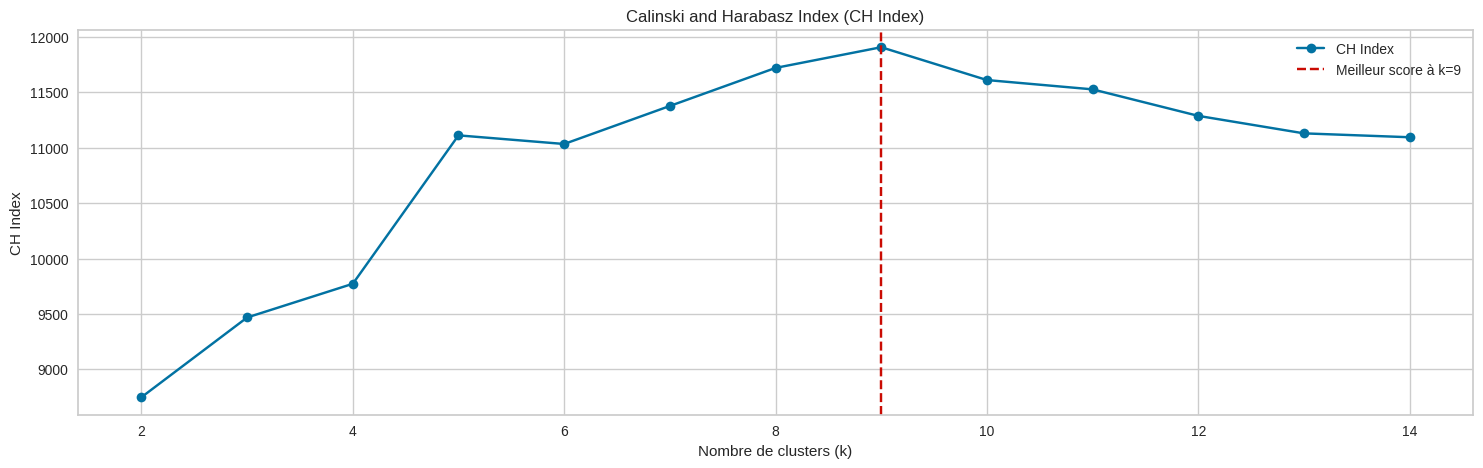

In [ ]:
fig = plt.figure(figsize=(18,5))

plt.plot(list(calinski_harabasz_scores.keys()), list(calinski_harabasz_scores.values()), marker="o", linestyle="-", label="CH Index")
plt.axvline(x=best_hac_k, color="r", linestyle="--", label=f"Meilleur score à k={best_hac_k}")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("CH Index")
plt.xlabel("Nombre de clusters (k)")
plt.title("Calinski and Harabasz Index (CH Index)")
plt.legend()

plt.show()

In [ ]:
ls = fcluster(Z, t=9, criterion='maxclust')
display(ls)

array([6, 1, 7, ..., 7, 9, 9], dtype=int32)

In [ ]:
%%time
hac = AgglomerativeClustering(n_clusters=9, metric='euclidean', linkage='ward')
labels_hac = hac.fit_predict(hac_data)
display(labels_hac)

array([8, 1, 6, ..., 6, 4, 4])

CPU times: user 32.5 s, sys: 1.78 s, total: 34.3 s
Wall time: 34.4 s


In [ ]:
%%time
results["HAC"] = {
    'Number of clusters': 9,
    'Silhouette score': silhouette_score(hac_data, labels_hac, metric='euclidean'),
    'Davies-Bouldin score': davies_bouldin_score(hac_data, labels_hac),
    }

CPU times: user 4.89 s, sys: 2.49 s, total: 7.39 s
Wall time: 5.2 s


# 7 | Comparaison des modéles

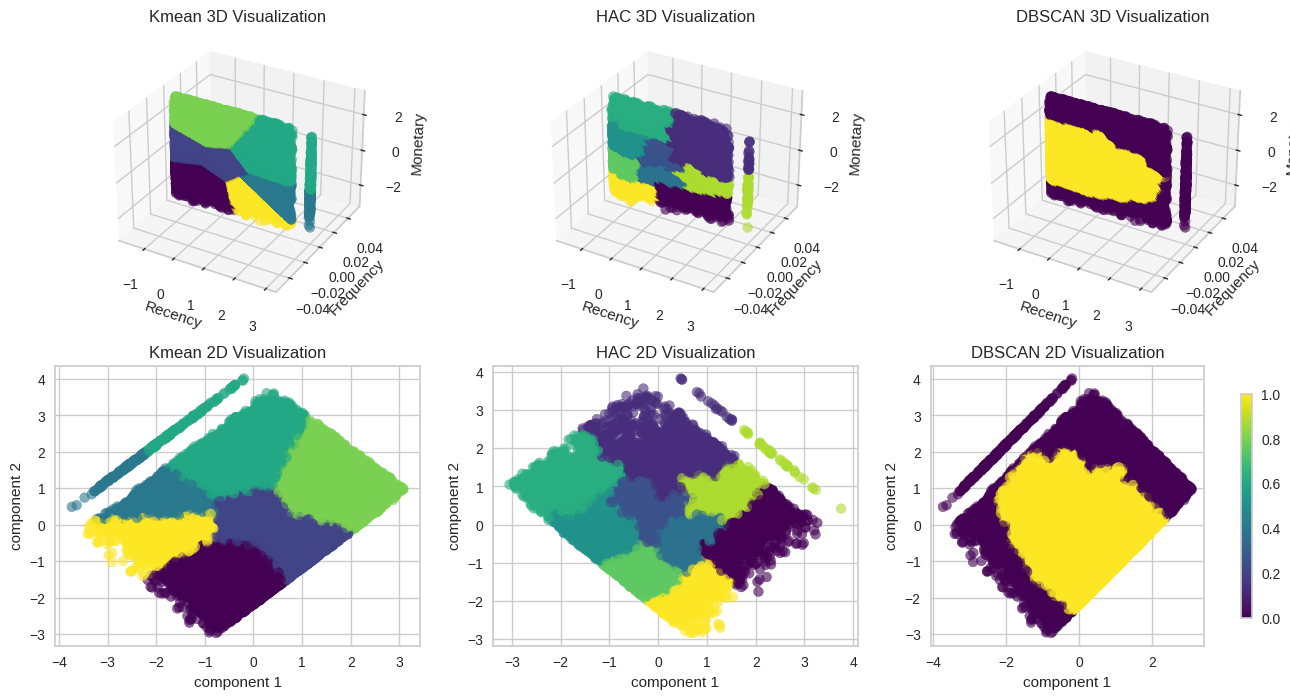

CPU times: user 17.8 s, sys: 74.3 ms, total: 17.8 s
Wall time: 17.5 s


In [ ]:
%%time
fig = plt.figure(figsize=(16, 8))

cmap = mpl.colormaps.get_cmap('viridis')

ax = fig.add_subplot(231, projection='3d')
ax.scatter(kmeans_data.recency, kmeans_data.frequency, kmeans_data.monetary, c=labels, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"Kmean 3D Visualization")
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel("Monetary")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans_data[['recency', 'frequency', 'monetary']])
ax = fig.add_subplot(2,3,4)
ax.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"Kmean 2D Visualization")
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')

ax = fig.add_subplot(232, projection='3d')
ax.scatter(hac_data.recency, hac_data.frequency, hac_data.monetary, c=labels_hac, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"HAC 3D Visualization")
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel("Monetary")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(hac_data[['recency', 'frequency', 'monetary']])
ax = fig.add_subplot(2,3,5)
ax.scatter(X_pca[:,0], X_pca[:,1], c=labels_hac, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"HAC 2D Visualization")
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')

ax = fig.add_subplot(233, projection='3d')
ax.scatter(dbscan_data.recency, dbscan_data.frequency, dbscan_data.monetary, c=labels_dbscan, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"DBSCAN 3D Visualization")
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel("Monetary")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(dbscan_data[['recency', 'frequency', 'monetary']])
ax = fig.add_subplot(2,3,6)
ax.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"DBSCAN 2D Visualization")
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)
plt.show()

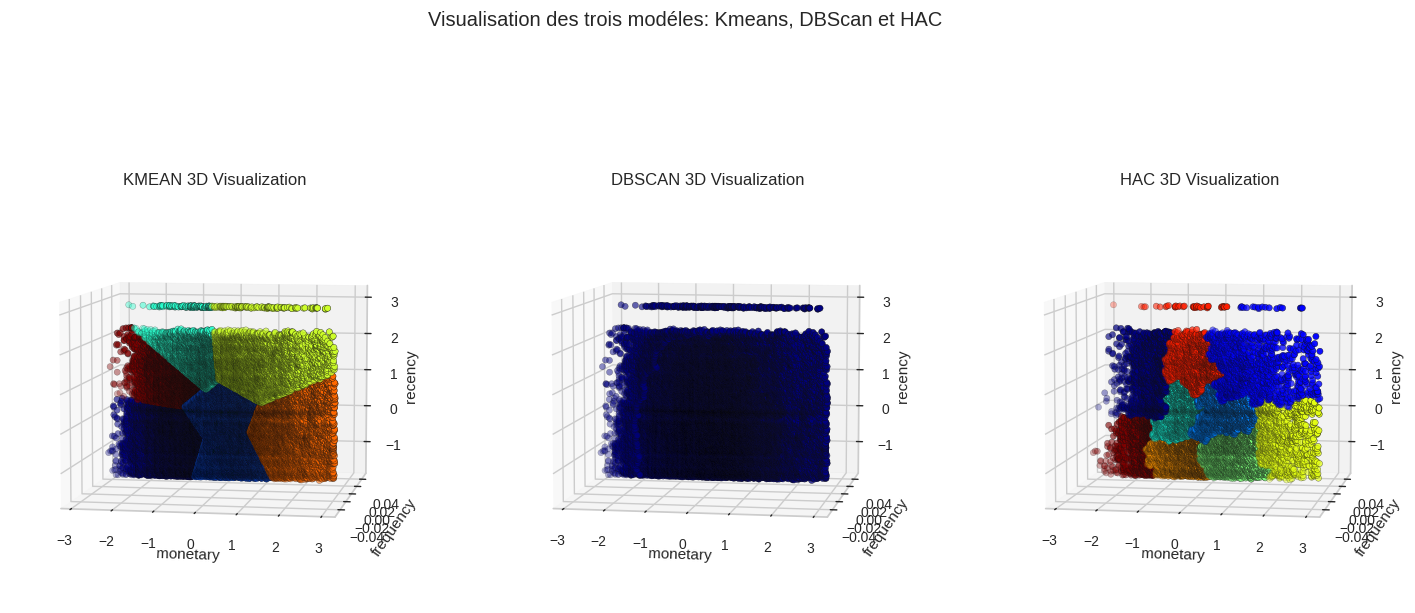

CPU times: user 15.1 s, sys: 71.4 ms, total: 15.1 s
Wall time: 14.9 s


In [ ]:
%%time
fig1 = plt.figure(figsize=(18, 8))

ax1 = fig1.add_subplot(131, projection="3d", elev=7, azim=-80)
#ax1.set_position([0, 0, 0.95, 1])
ax1.set_xlabel('monetary')
ax1.set_ylabel('frequency')
ax1.set_zlabel("recency")
ax1.set_title(f"KMEAN 3D Visualization")
for l in np.unique(labels):
    ax1.scatter(
        first_selection_df.loc[first_selection_df.cluster == l, 'monetary'],
        first_selection_df.loc[first_selection_df.cluster  == l, 'frequency'],
        first_selection_df.loc[first_selection_df.cluster  == l, 'recency'],
        color=plt.cm.jet(float(l) / np.max(labels)),
        s=20,
        edgecolor="k",
    )

ax2 = fig1.add_subplot(132, projection="3d", elev=7, azim=-80)
#ax2.set_position([0, 0, 0.95, 1])
ax2.set_xlabel('monetary')
ax2.set_ylabel('frequency')
ax2.set_zlabel("recency")
ax2.set_title(f"DBSCAN 3D Visualization")
dbscan_data__ = dbscan_data.copy()
dbscan_data__.loc[:,'cluster'] = labels_dbscan
for l in np.unique(labels_dbscan):
    ax2.scatter(
        dbscan_data__.loc[dbscan_data__.cluster == l, 'monetary'],
        dbscan_data__.loc[dbscan_data__.cluster  == l, 'frequency'],
        dbscan_data__.loc[dbscan_data__.cluster  == l, 'recency'],
        color=plt.cm.jet(float(l) / np.max(labels_dbscan +1)),
        s=20,
        edgecolor="k",
    )

ax2 = fig1.add_subplot(133, projection="3d", elev=7, azim=-80)
#ax2.set_position([0, 0, 0.95, 1])
ax2.set_xlabel('monetary')
ax2.set_ylabel('frequency')
ax2.set_zlabel("recency")
ax2.set_title(f"HAC 3D Visualization")
hac_data__ = hac_data.copy()
hac_data__.loc[:,'cluster'] = labels_hac
for l in np.unique(labels_hac):
    ax2.scatter(
        hac_data__.loc[hac_data__.cluster == l, 'monetary'],
        hac_data__.loc[hac_data__.cluster  == l, 'frequency'],
        hac_data__.loc[hac_data__.cluster  == l, 'recency'],
        color=plt.cm.jet(float(l) / np.max(labels_hac)),
        s=20,
        edgecolor="k",
    )
_ = fig1.suptitle(f"Visualisation des trois modéles: Kmeans, DBScan et HAC")
plt.show()

In [ ]:
result_df = pd.DataFrame(results).T
result_df

,Number of clusters,Silhouette score,Davies-Bouldin score
KMEANS,6.0,0.511723,0.682474
DBSCAN,2.0,0.342019,3.002105
HAC,9.0,0.285458,0.915293


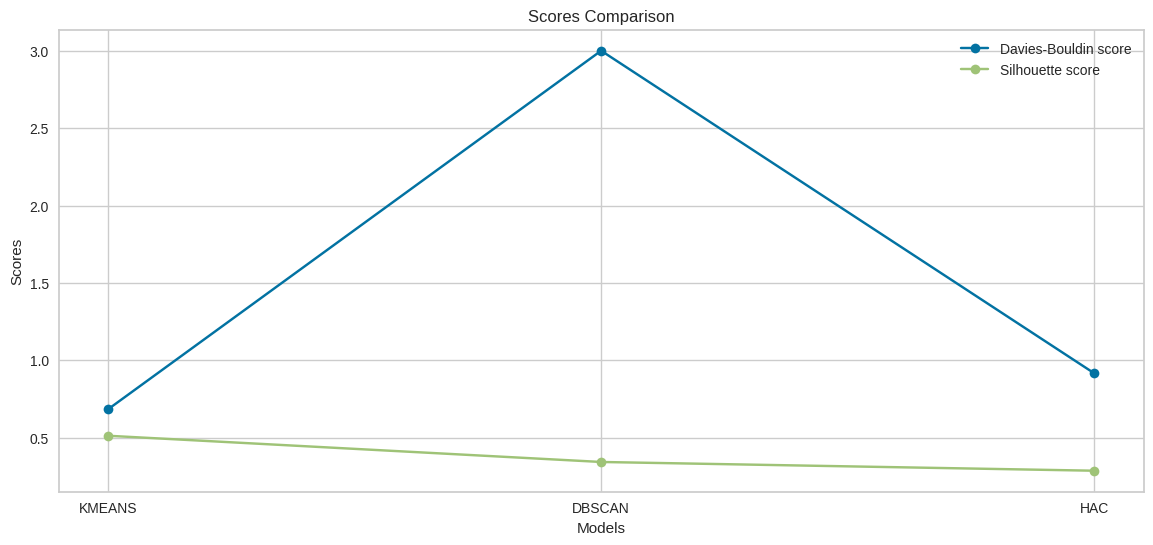

In [ ]:
fig = plt.figure(figsize=(14, 6))
plt.plot(result_df['Davies-Bouldin score'], marker='o', linestyle='-', label='Davies-Bouldin score')
plt.plot(result_df['Silhouette score'], marker='o', linestyle='-', label='Silhouette score')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Scores Comparison')
plt.legend()
plt.show()
#plt.gca().spines[['top', 'right']].set_visible(False)

# 8 | Interpretation des clusters Kmeans

## 8.1 | Interpretation des clients normaux

In [ ]:
df = data.copy()
df.loc[:,'cluster'] = labels

In [ ]:
## 7.1 | Statistique des clusters

In [ ]:
df.groupby('cluster').agg({
    'recency': ['mean', 'min', 'max'],
    'monetary': ['mean', 'min', 'max']}).T

cluster                 0           1           2           3           4  \
recency  mean  143.308789  171.667892  482.170914  455.924643  178.989246   
         min     0.000000    0.000000  358.000000  309.000000    0.000000   
         max   314.000000  399.000000  694.000000  694.000000  421.000000   
monetary mean    3.808164    4.792655    4.188598    5.267381    5.877571   
         min     2.516890    3.998384    2.924236    4.524719    5.243703   
         max     4.398638    5.656691    4.640055    6.852010    6.858155   

cluster                 5  
recency  mean  379.250500  
         min   287.000000  
         max   601.000000  
monetary mean    3.765389  
         min     2.556452  
         max     4.401952

**Recency** : plus le nombre est grand, plus le dernier achat est ancien.

**Monetary** : la variable est en échelle log ; une valeur plus grande indique des dépenses totales plus élevées (de façon exponentielle).


1.  Cluster 0

  - **Recency moyen :** ~143 jours (min = 0, max = 314)
  - **Monetary moyen :** ~3.81 (min = 2.52, max = 4.40)
  - **Interprétation :**
      - Des clients dont le dernier achat remonte à environ 4-5 mois en moyenne, mais on trouve aussi des clients ayant acheté tout récemment (recency = 0).
      - Leur niveau de dépenses est plutôt moyen.
      - On peut les qualifier de « clients à activité modérée », parfois très récents, parfois plus anciens, avec un budget moyen.

2. Cluster 1

  - **Recency moyen :** ~172 jours (min = 0, max = 399)
  - **Monetary moyen :** ~4.79 (min = 4.00, max = 5.66)
  - **Interprétation :**
    - Recency dans la même zone que le Cluster 0 (entre récent et 1 an+).
    - Le niveau de dépense est cependant plus élevé (4.79) que dans le Cluster 0.
    - On peut considérer ces clients comme « clients au budget plus important » que le Cluster 0, même si leur dernière transaction peut parfois remonter à plusieurs mois.

3. Cluster 2

  - **Recency moyen :** ~482 jours (min = 358, max = 694)
  - **Monetary moyen :** ~4.19 (min = 2.92, max = 4.64)
  - **Interprétation :**
    - Des clients « très inactifs » (plus d’un an sans achat en moyenne).
    - Budget plutôt moyen (4.19), ni le plus bas ni le plus élevé.
    - Probablement des clients « en risque d’attrition » (ils n’ont pas acheté depuis longtemps), mais qui avaient un panier moyen correct.

4. Cluster 3

  - **Recency moyen :** ~456 jours (min = 309, max = 694)
  - **Monetary moyen :** ~5.27 (min = 4.52, max = 6.85)
  - **Interprétation :**
    - Des clients également « très inactifs » (dernière commande il y a plus d’un an).
    - Leur budget est relativement élevé (5.27) : ils dépensaient plus que la moyenne.
    - On peut les considérer comme d’anciens bons clients qui ont arrêté d’acheter depuis longtemps.
    - Intéressant à cibler pour des actions de réactivation (ils avaient un panier élevé).

4. Cluster 4

  - **Recency moyen :** ~179 jours (min = 0, max = 421)
  - **Monetary moyen :** ~5.88 (min = 5.24, max = 6.86)
  - **Interprétation :**
    - Recency proche de 6 mois en moyenne, mais on retrouve des clients très récents (0) et d’autres jusqu’à plus d’un an (421).
    - Meilleur score monétaire (5.88) : ce sont les « plus gros dépensiers » parmi tous les clusters.
    - On peut considérer qu’ils restent actifs (pas autant que dans le Cluster 0 ou 1 en termes de recency moyen, mais pas aussi inactifs que dans le Cluster 2 ou 3), tout en ayant un panier élevé.
    - Ce sont des clients hautement profitables qu’il faut fidéliser.

5. Cluster 5

  - **Recency moyen :** ~379 jours (min = 287, max = 601)
  - **Monetary moyen :** ~3.77 (min = 2.56, max = 4.40)
  - **Interprétation :**
    - Recency élevé (environ 1 an sans achat), proche du Cluster 2 ou 3, mais parfois un peu moins (min = 287).
    - Budget moyen plutôt modeste (3.77), semblable au Cluster 0.
    - Ils ont quitté la marque depuis presque un an ou plus, sans avoir dépensé beaucoup auparavant.
    - Moins de potentiel que le Cluster 3, mais toujours intéressant si vous souhaitez réactiver un maximum de clients inactifs.

**Stratégie par Segments de Clients**

1. Clients inactifs depuis longtemps (plus d’un an)
  - **Cluster 3**  
    - Potentiel plus élevé grâce à un budget important  
    - Cible prioritaire pour la réactivation (ROI plus élevé)
    
  - **Cluster 2**  
    - Budget moyen  
    - Réactivation à envisager après le Cluster 3
    
  - **Cluster 5**  
    - Budget plus faible  
    - Réactivation possible, mais avec un potentiel moins important

2. Clients plus actifs ou avec une recency plus faible
  - **Cluster 4**  
    - Le plus intéressant en termes de budget (gros paniers)  
    - Prioriser la fidélisation de ces clients

  - **Cluster 1**  
    - Panier moyen supérieur à Cluster 0, avec une recency similaire  
    - Nécessite des offres adaptées pour maintenir leur intérêt
    
  - **Cluster 0**  
    - Situation moyenne sur les deux dimensions  
    - Maintenir leur engagement via des stratégies de fidélisation adaptées

```markdown
| Cluster | Nom                                  |
|---------|--------------------------------------|
| 0       | Récents à dépense modérée            |
| 1       | Récents à dépense modérée            |
| 2       | En perte de vitesse                  |
| 3       | Gros dépensiers inactifs             |
| 4       | Champions récents                    |
| 5       | Inactifs à dépense modérée           |
```

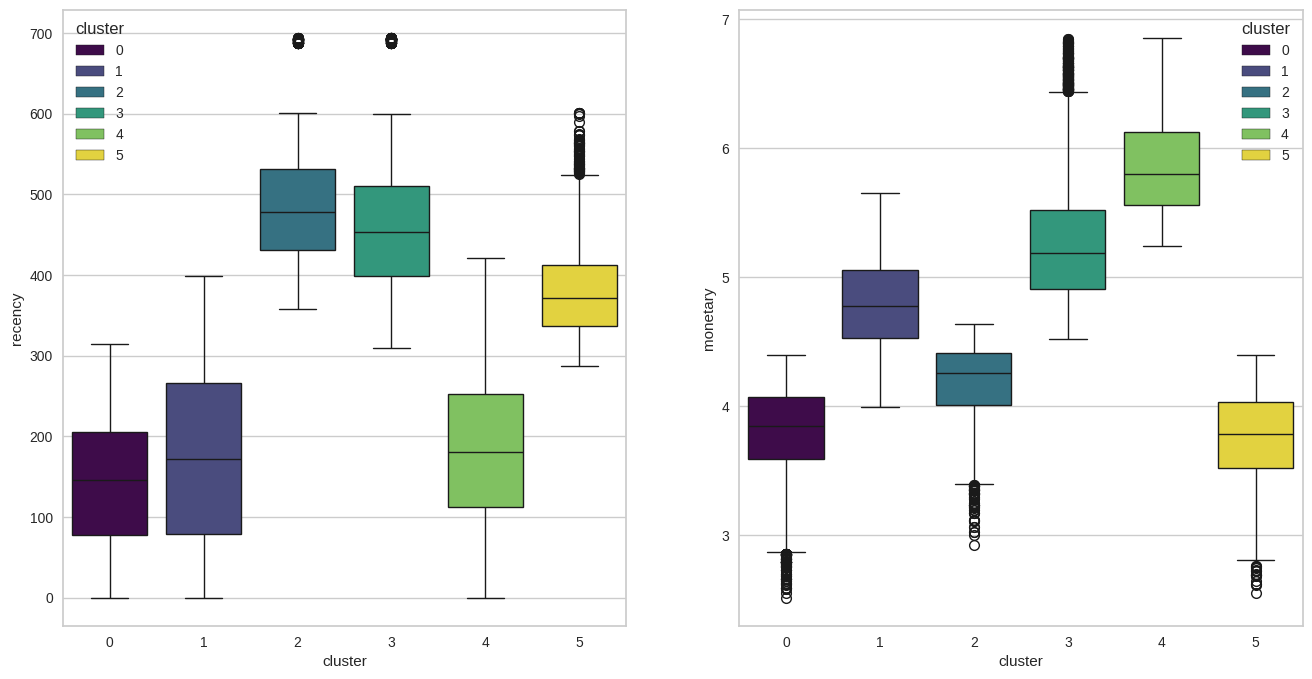

In [ ]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1,2,1)
sns.boxplot(data=df, x='cluster', y='recency', hue='cluster', ax=ax1, palette='viridis')
ax2 = fig.add_subplot(1,2,2)
sns.boxplot(data=df, x='cluster', y='monetary', hue='cluster', ax=ax2, palette='viridis')

plt.show()

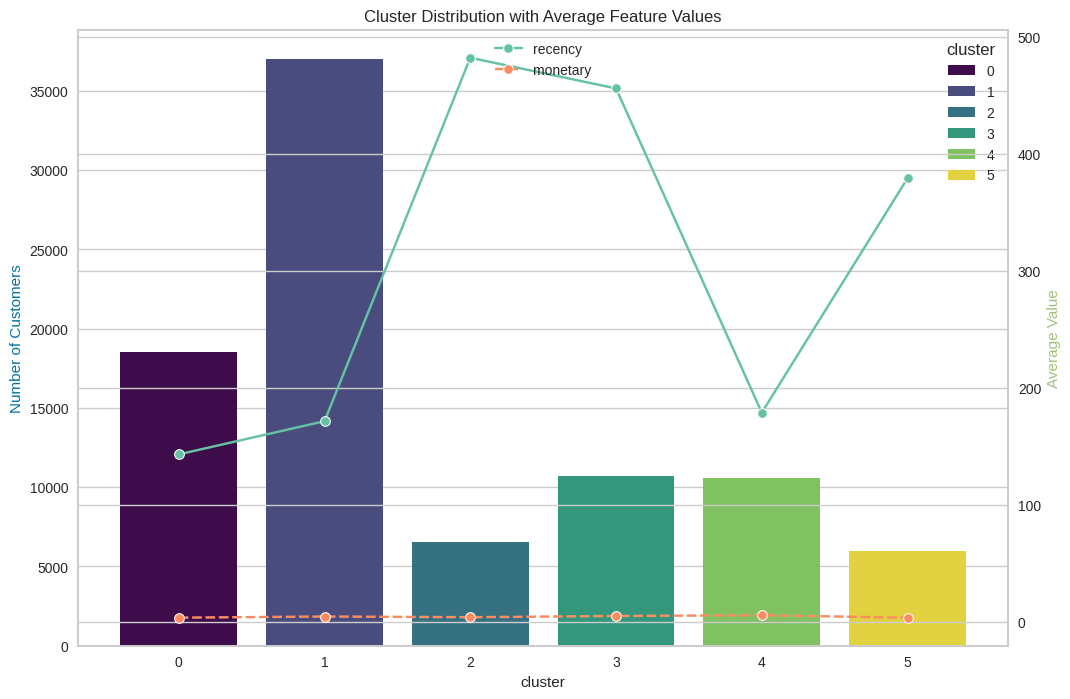

In [ ]:
cluster_counts = df['cluster'].value_counts()
#df["MonetaryValue per 100 pounds"] = df["MonetaryValue"] / 100.00
#feature_means = df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean()
feature_means = df.groupby('cluster')[['recency', 'monetary']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o', legend='brief')
ax2.set_ylabel('Average Value', color='g')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0))

plt.show()


## 8.2 | Interpretation des clients atypiques

Ces clients correspondent à des client qui ont soient:
- une faible frequence mais de gros montants
- de grosse frequence mais de faible montant
- soient de grosses montant avec de grosses frequences, que nous avons identifiés comme des outliers

In [ ]:
monetary_only_outliers["cluster"] = -1
frequency_only_outliers["cluster"] = -2
monetary_and_frequency_outliers["cluster"] = -3

In [ ]:
outliers_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])
outliers_df.groupby('cluster').agg({'recency': ['mean', 'min', 'max'], 'monetary': ['mean', 'min', 'max'], 'frequency': ['mean', 'min', 'max']}).T

cluster                 -3          -2          -1
recency   mean  203.506466  222.429183  242.805004
          min     3.000000    0.000000    3.000000
          max   689.000000  691.000000  693.000000
monetary  mean    7.399723    5.958109    7.243495
          min     6.861586    4.274998    2.260721
          max     9.832181    6.859132    9.522526
frequency mean    2.480603    2.041078    1.000000
          min     2.000000    2.000000    1.000000
          max    15.000000    6.000000    1.000000

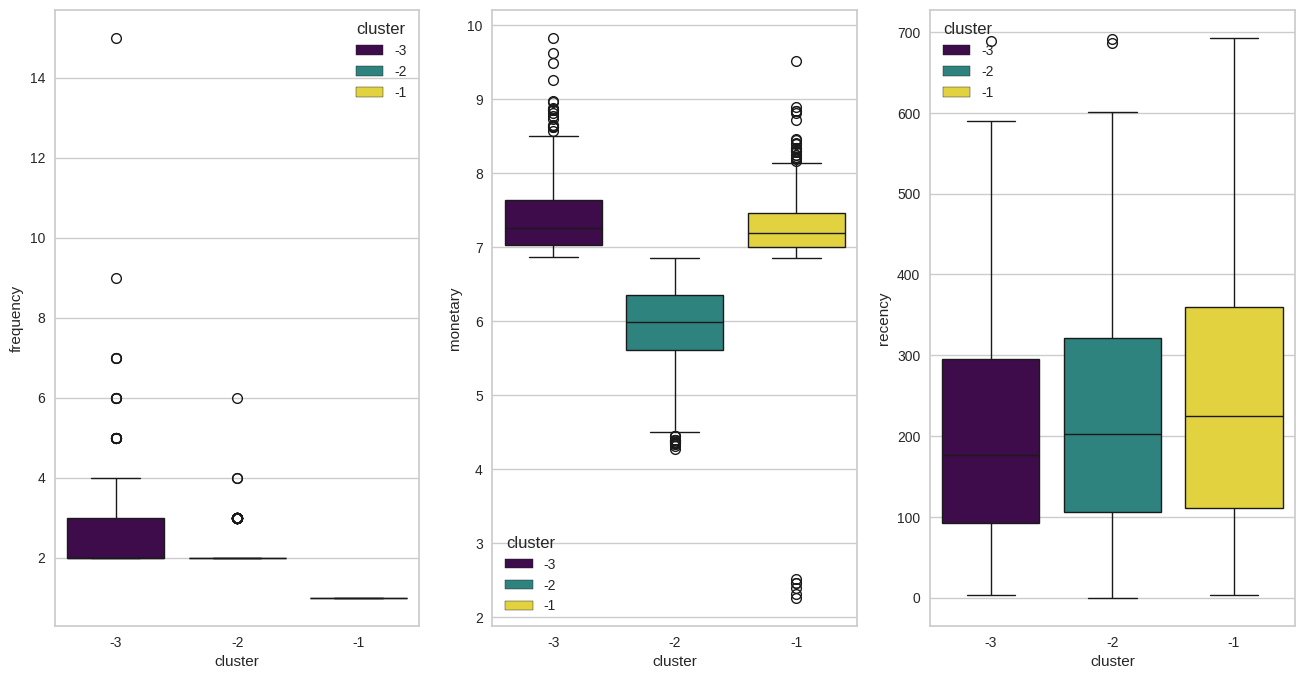

In [ ]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1,3,1)
sns.boxplot(data=outliers_df, x='cluster', y='frequency', hue='cluster', ax=ax1, palette='viridis')
ax2 = fig.add_subplot(1,3,2)
sns.boxplot(data=outliers_df, x='cluster', y='monetary', hue='cluster', ax=ax2, palette='viridis')
ax3 = fig.add_subplot(1,3,3)
sns.boxplot(data=outliers_df, x='cluster', y='recency', hue='cluster', ax=ax3, palette='viridis')

plt.show()

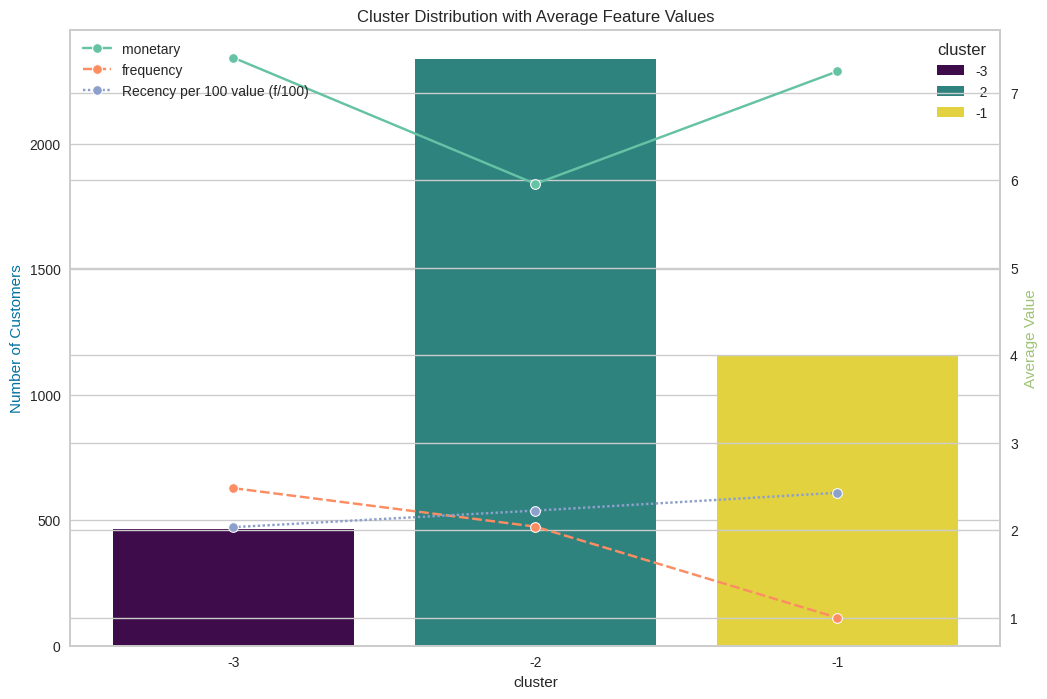

In [ ]:
cluster_counts = outliers_df['cluster'].value_counts()
outliers_df["Recency per 100 value (f/100)"] = outliers_df["recency"] / 100.00
#feature_means = outliers_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean()
feature_means = outliers_df.groupby('cluster')[['monetary', 'frequency', 'Recency per 100 value (f/100)']].mean().reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index, dodge=False)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o', legend='auto')
ax2.set_ylabel('Average Value', color='g')
ax2.legend(loc='upper left')

plt.show()


Les trois clusters ci-dessous sont identifiés comme « outliers » du fait de leurs caractéristiques atypiques (valeurs extrêmes en termes de frequency ou monetary).

---

1. Cluster -3

  - **Recency**  
    - Moyenne : ~203 jours (min = 3, max = 689)  
    - Intervalle assez large : certains clients sont inactifs depuis quelques jours seulement, d’autres depuis près de deux ans.

  - **Monetary**  
    - Moyenne : ~7.40 (min = 6.86, max = 9.83)  
    - Valeurs plutôt élevées : ce sont des clients avec un panier moyen (ou total) conséquent.

  - **Frequency**  
    - Moyenne : ~2.48 (min = 2, max = 15)  
    - La fréquence peut aller jusqu’à 15 transactions, mais la majorité est autour de 2-3 achats.

  **Interprétation :**  
  Ces clients achètent **plusieurs fois** (2 transactions ou plus), avec des **montants élevés** (monetary élevé). Leur recency moyenne (environ 200 jours) indique qu’ils ne sont pas forcément très actifs récemment, mais ils ont montré par le passé un **comportement d’achat significatif** (panier élevé, fréquence > 1). On peut les considérer comme des **« gros acheteurs ponctuels »**, potentiellement intéressants à **réactiver** s’ils n’ont pas commandé depuis un moment.


2. Cluster -2

  - **Recency**  
    - Moyenne : ~222 jours (min = 0, max = 691)  
    - Là aussi, grande variabilité : certains sont très récents (0 jour), d’autres n’ont pas acheté depuis près de deux ans.

  - **Monetary**  
    - Moyenne : ~5.96 (min = 4.27, max = 6.86)  
    - Montants élevés, mais **moins** que le Cluster -3 ou -1.

  - **Frequency**  
    - Moyenne : ~2.04 (min = 2, max = 6)  
    - Les clients réalisent en général **plus d’une transaction** (2 en moyenne).

  **Interprétation :**  
  Ces clients ont un **niveau de dépenses élevé** (mais un peu moins que -3) et **plusieurs achats**. Leur recency est également importante (environ 7 mois en moyenne), avec de fortes disparités. On peut les voir comme des **« bons acheteurs »** mais plus dispersés dans le temps, et dont la dépense est inférieure à celle du Cluster -3. Une **stratégie de fidélisation** pourrait être envisagée pour maintenir leur engagement.


3. Cluster -1

  - **Recency**  
    - Moyenne : ~243 jours (min = 3, max = 693)  
    - Dans la moyenne haute, certains n’ont pas acheté depuis longtemps.

  - **Monetary**  
    - Moyenne : ~7.24 (min = 2.26, max = 9.52)  
    - Niveau de dépense très élevé pour certains, même si la valeur minimale peut être plus faible.

  - **Frequency**  
    - Moyenne : **1.00** (min = 1, max = 1)  
    - Tous les clients de ce cluster n’ont effectué **qu’une seule transaction**.

  **Interprétation :**  
  Ce sont des **« one-shot buyers »** qui ont un **panier moyen (ou total) important** lors de leur unique achat. Leur recency élevée (plus de 8 mois en moyenne) suggère qu’ils **n’ont pas réitéré** leur achat. Ils représentent un **segment à fort potentiel** (montant élevé) mais **non fidélisé** (une seule transaction). Pour ce cluster, il peut être intéressant de mener des **actions de réactivation ciblées** (offres spécifiques, relances) pour les encourager à revenir.



**Conclusion**

- **Cluster -3** : Clients ayant **plusieurs transactions** et un **haut niveau de dépense**, mais dont l’activité récente est irrégulière.  
- **Cluster -2** : Clients avec **2+ transactions**, un **budget élevé** (moins que -3), et une recency relativement importante.  
- **Cluster -1** : **Gros dépensiers ponctuels**, n’ayant fait qu’**une seule transaction** (one-shot) et qui n’ont pas été fidélisés.

Chacun de ces clusters requiert des **actions marketing** spécifiques :  
- **-3 et -2** : Programmes de **réactivation** ou de **fidélisation** (puisqu’ils ont déjà commandé plusieurs fois).  
- **-1** : **Réactivation** et incitation à renouveler l’achat (fort potentiel de panier moyen, mais pas de récurrence).  


## 8.3 | Interpretation grobale

In [ ]:
final_df = pd.concat([df, outliers_df])

In [ ]:
final_df.head()

,customer_unique_id,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,first_purch_at,last_purch_at,last_purch_day_of_week,customer_zip_code_prefix,rfm_segment_loyalty,cluster,Recency per 100 value (f/100)
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,4.955123,8,413,5.0,1.0,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,3,7787,top (Gold),1,NaN
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,3.302849,6,411,4.0,1.0,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,6053,risk (bronze),0,NaN
2,0000f46a3911fa3c0805444483337064,536,1,4.456902,4,112,3.0,1.0,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,4,88115,inactive,2,NaN
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,3.775516,4,211,4.0,1.0,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,3,66812,inactive,5,NaN
4,0004aac84e0df4da2b147fca70cf8255,287,1,5.282645,7,214,5.0,1.0,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,1,18040,good (silver),1,NaN


1.  **Clusters « standards » (0 à 5)**
    
    1.1 |  Cluster 0

      - **Recency moyen :** ~143 jours (min = 0, max = 314)
      - **Monetary moyen :** ~3.81 (min = 2.52, max = 4.40)
      - **Interprétation :**
          - Des clients dont le dernier achat remonte à environ 4-5 mois en moyenne, mais on trouve aussi des clients ayant acheté tout récemment (recency = 0).
          - Leur niveau de dépenses est plutôt moyen.
          - On peut les qualifier de « clients à activité modérée », parfois très récents, parfois plus anciens, avec un budget moyen.

    1.2 | Cluster 1

      - **Recency moyen :** ~172 jours (min = 0, max = 399)
      - **Monetary moyen :** ~4.79 (min = 4.00, max = 5.66)
      - **Interprétation :**
        - Recency dans la même zone que le Cluster 0 (entre récent et 1 an+).
        - Le niveau de dépense est cependant plus élevé (4.79) que dans le Cluster 0.
        - On peut considérer ces clients comme « clients au budget plus important » que le Cluster 0, même si leur dernière transaction peut parfois remonter à plusieurs mois.

    1.3 | Cluster 2

      - **Recency moyen :** ~482 jours (min = 358, max = 694)
      - **Monetary moyen :** ~4.19 (min = 2.92, max = 4.64)
      - **Interprétation :**
        - Des clients « très inactifs » (plus d’un an sans achat en moyenne).
        - Budget plutôt moyen (4.19), ni le plus bas ni le plus élevé.
        - Probablement des clients « en risque d’attrition » (ils n’ont pas acheté depuis longtemps), mais qui avaient un panier moyen correct.

    1.4 | Cluster 3

      - **Recency moyen :** ~456 jours (min = 309, max = 694)
      - **Monetary moyen :** ~5.27 (min = 4.52, max = 6.85)
      - **Interprétation :**
        - Des clients également « très inactifs » (dernière commande il y a plus d’un an).
        - Leur budget est relativement élevé (5.27) : ils dépensaient plus que la moyenne.
        - On peut les considérer comme d’anciens bons clients qui ont arrêté d’acheter depuis longtemps.
        - Intéressant à cibler pour des actions de réactivation (ils avaient un panier élevé).

    1.5 | Cluster 4

      - **Recency moyen :** ~179 jours (min = 0, max = 421)
      - **Monetary moyen :** ~5.88 (min = 5.24, max = 6.86)
      - **Interprétation :**
        - Recency proche de 6 mois en moyenne, mais on retrouve des clients très récents (0) et d’autres jusqu’à plus d’un an (421).
        - Meilleur score monétaire (5.88) : ce sont les « plus gros dépensiers » parmi tous les clusters.
        - On peut considérer qu’ils restent actifs (pas autant que dans le Cluster 0 ou 1 en termes de recency moyen, mais pas aussi inactifs que dans le Cluster 2 ou 3), tout en ayant un panier élevé.
        - Ce sont des clients hautement profitables qu’il faut fidéliser.

    1.6 | Cluster 5

      - **Recency moyen :** ~379 jours (min = 287, max = 601)
      - **Monetary moyen :** ~3.77 (min = 2.56, max = 4.40)
      - **Interprétation :**
        - Recency élevé (environ 1 an sans achat), proche du Cluster 2 ou 3, mais parfois un peu moins (min = 287).
        - Budget moyen plutôt modeste (3.77), semblable au Cluster 0.
        - Ils ont quitté la marque depuis presque un an ou plus, sans avoir dépensé beaucoup auparavant.
        - Moins de potentiel que le Cluster 3, mais toujours intéressant si vous souhaitez réactiver un maximum de clients inactifs.


2.  **Clusters « outliers » (-3, -2, -1)**

  2.1  Cluster -3 : “VIP multi-acheteurs (hors norme)”
    - **Recency** : Intermédiaire.
    - **Monetary** : Très élevée.
    - **Frequency** : Non négligeable.
    - **Interprétation** : Plusieurs achats à très gros montants, mais plus récents que ceux de -2 ou -1. Un segment ultra rentable à réactiver et fidéliser.

  2.2 Cluster -2 : “Gros acheteurs inactifs (hors norme)”
    - **Recency** : Un peu plus élevée que -3.
    - **Monetary** : Élevée (moins extrême que -3).
    - **Frequency** : Modérée.
    - **Interprétation** : Anciens clients à gros panier, mais moins extrêmes que ceux de -3. À relancer.

  2.3 Cluster -1 : “One-shot big spenders (hors norme)”
    - **Recency** : Élevée.
    - **Monetary** : Très élevée.
    - **Frequency** : Quasi nulle (un seul achat).
    - **Interprétation** : Clients ayant réalisé un unique achat de très gros montant, puis inactifs. Potentiel intéressant nécessitant une stratégie de reconquête spécifique.


In [ ]:
cluster_names = {
    0: "Récents à dépense modérée",
    1: "Récents à dépense modérée",
    2: "En perte de vitesse",
    3: "Gros dépensiers inactifs",
    4: "Champions récents",
    5: "Inactifs à dépense modérée",
    -3: "VIP multi-acheteurs (hors norme)",
    -2: "Gros acheteurs inactifs (hors norme)",
    -1: "One-shot big spenders (hors norme)"
}

In [ ]:
final_df['cluster_label'] = final_df.cluster.map(cluster_names)

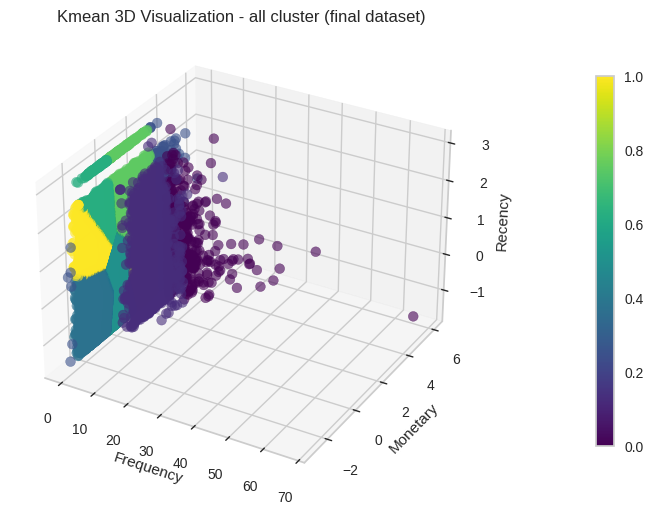

In [ ]:
ss = StandardScaler()
copy_data = final_df.copy()
copy_data[['recency', 'monetary', 'frequency']] = ss.fit_transform(copy_data[['recency', 'monetary', 'frequency']])
fig = plt.figure(figsize=(16, 6))

cmap = mpl.colormaps.get_cmap('viridis')

ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=copy_data.frequency, ys=copy_data.monetary, zs=copy_data.recency, c=copy_data.cluster, cmap=cmap, s=50, alpha=0.6)
ax.set_title(f"Kmean 3D Visualization - all cluster (final dataset)")
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel("Recency")
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

plt.show()

```markdown
| Cluster | Nom                                  | Origin    |
|---------|--------------------------------------|-----------|
| 0       | Récents à dépense modérée            | Standards |
| 1       | Récents à dépense modérée            | Standards |
| 2       | En perte de vitesse                  | Standards |
| 3       | Gros dépensiers inactifs             | Standards |
| 4       | Champions récents                    | Standards |
| 5       | Inactifs à dépense modérée           | Standards |
| -3      | VIP multi-acheteurs (hors norme)     | Outliers  |
| -2      | Gros acheteurs inactifs (hors norme) | Outliers  |
| -1      | One-shot big spenders (hors norme)   | Outliers  |
```

In [ ]:
t_final = time.time()
print(f"La durée d'execution compléte du notebook est de: {t_final - t_init} secondes")

La durée d'execution compléte du notebook est de: 1677.8739926815033 secondes


# FIN